In [1]:
from utils import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
import warnings
warnings.filterwarnings('ignore')

fe = Feature_engineering()
woe = WoE()
corr_methods = Correlation_methods()
plots = Plots()

# feature engineering

In [2]:
data = pd.read_csv("data/train.csv")

## correlations

In [3]:
# point_biserial
cols = data.drop(columns=['smoking']).columns
pb_values = []
for column in cols:
    pb = corr_methods.r_pb(binary_variable=data['smoking'], continuous_variable=data[column])
    pb_values.append([column, pb[0], pb[1]])

r_pb_df = pd.DataFrame(columns=['Feature', 'Coefficient', 'P_Value'], data=pb_values)
r_pb_df.sort_values(by='Coefficient', ascending=False)

# gemoglobin, height va weight yaxshi correlatsiya ko'rsatmoqda
# hdl va age da teskari correlatsiya

Feature  Coefficient        P_Value
16           hemoglobin     0.503442   0.000000e+00
2            height(cm)     0.494092   0.000000e+00
3            weight(kg)     0.399787   0.000000e+00
21                  Gtp     0.377667   0.000000e+00
18     serum creatinine     0.351120   0.000000e+00
13         triglyceride     0.345541   0.000000e+00
4             waist(cm)     0.300887  1.894587e-311
20                  ALT     0.241721  2.261447e-198
10           relaxation     0.152125   2.380210e-78
22        dental caries     0.148421   1.246983e-74
6       eyesight(right)     0.134564   1.481217e-61
5        eyesight(left)     0.128234   5.071650e-56
9              systolic     0.123260   7.265360e-52
11  fasting blood sugar     0.103526   5.043324e-37
19                  AST     0.101480   1.236767e-35
8        hearing(right)    -0.002186   7.889244e-01
7         hearing(left)    -0.007418   3.636083e-01
17        Urine protein    -0.008566   2.941588e-01
0                    id    -0.015152   6.349591e-02
12          Cholesterol    -0.034782   2.036774e-05
15                  LDL    -0.035665   1.247492e-05
1                   age    -0.193103  5.807794e-126
14                  HDL    -0.290750  5.011477e-290

In [4]:
binary_cols = data.columns[data.apply(lambda x: x.nunique() == 2 and x.dropna().isin([0, 1]).all())].drop('smoking')
phi_values = []
for col in binary_cols:
    phi_coef = corr_methods.phi_coefficient(data['smoking'], data[col])
    phi_values.append([col, phi_coef])
phi_df = pd.DataFrame(columns=['Feature', 'Coefficient'], data=phi_values)
phi_df

# target binary featurega nisbatan katta bo'lmagan korrelatsiyaga ega

Feature  Coefficient
0  dental caries     0.148421

## data

In [5]:
data.head()

id   age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
0   0  55.0       170.0        80.0       92.0             1.2   
1   1  30.0       170.0        80.0       94.0             1.5   
2   2  45.0       170.0        75.0       84.0             1.0   
3   3  55.0       150.0        55.0       85.0             0.9   
4   4  45.0       160.0        55.0       72.0             0.5   

   eyesight(right)  hearing(left)  hearing(right)  systolic  ...   HDL    LDL  \
0              0.8            1.0             1.0     129.0  ...  49.0  114.0   
1              1.5            1.0             1.0     128.0  ...  51.0  111.0   
2              1.0            1.0             1.0     124.0  ...  52.0  112.0   
3              0.5            1.0             1.0     123.0  ...  61.0  119.0   
4              0.6            1.0             1.0     117.0  ...  61.0  120.0   

   hemoglobin  Urine protein  serum creatinine   AST   ALT   Gtp  \
0        15.4            1.0               0.9  20.0  23.0  13.0   
1        16.2            1.0               0.9  30.0  39.0  92.0   
2        14.6            2.0               0.9  20.0  20.0  50.0   
3        13.4            1.0               0.8  25.0  20.0  18.0   
4        13.9            1.0               0.7  20.0  26.0  10.0   

   dental caries  smoking  
0            0.0      0.0  
1            0.0      1.0  
2            0.0      1.0  
3            0.0      0.0  
4            0.0      0.0  

[5 rows x 24 columns]

<Figure size 800x600 with 0 Axes>

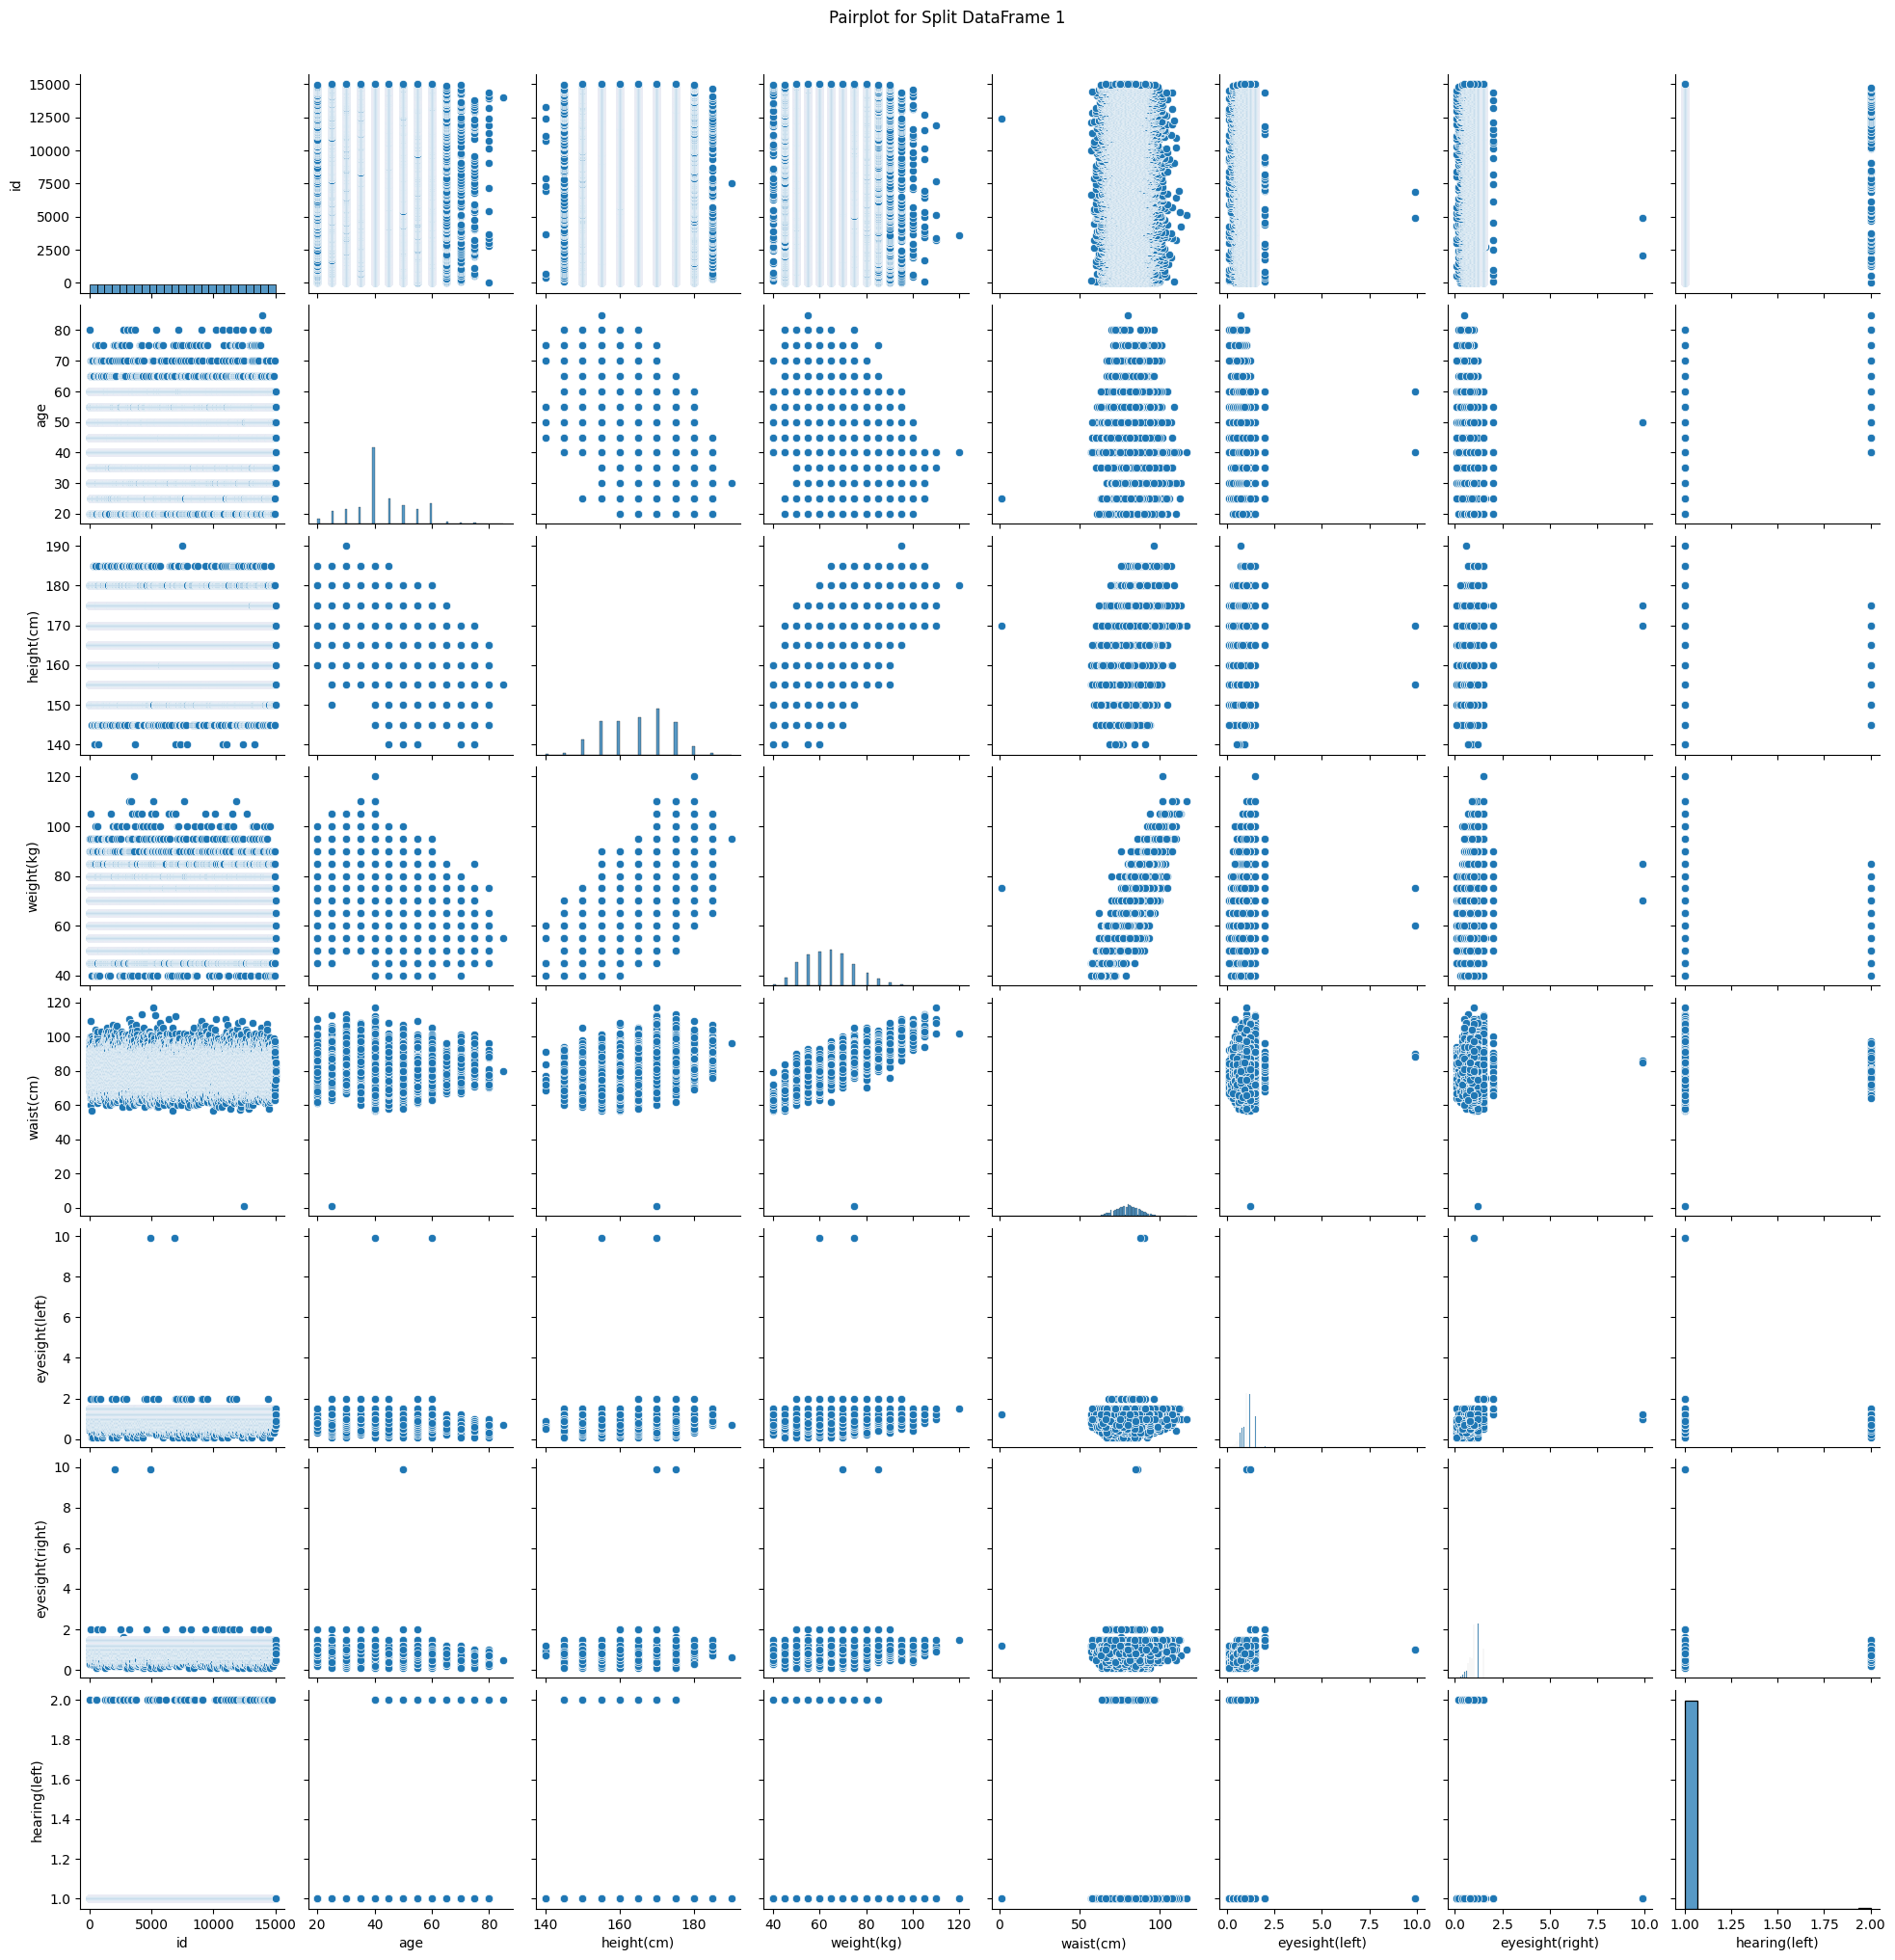

<Figure size 800x600 with 0 Axes>

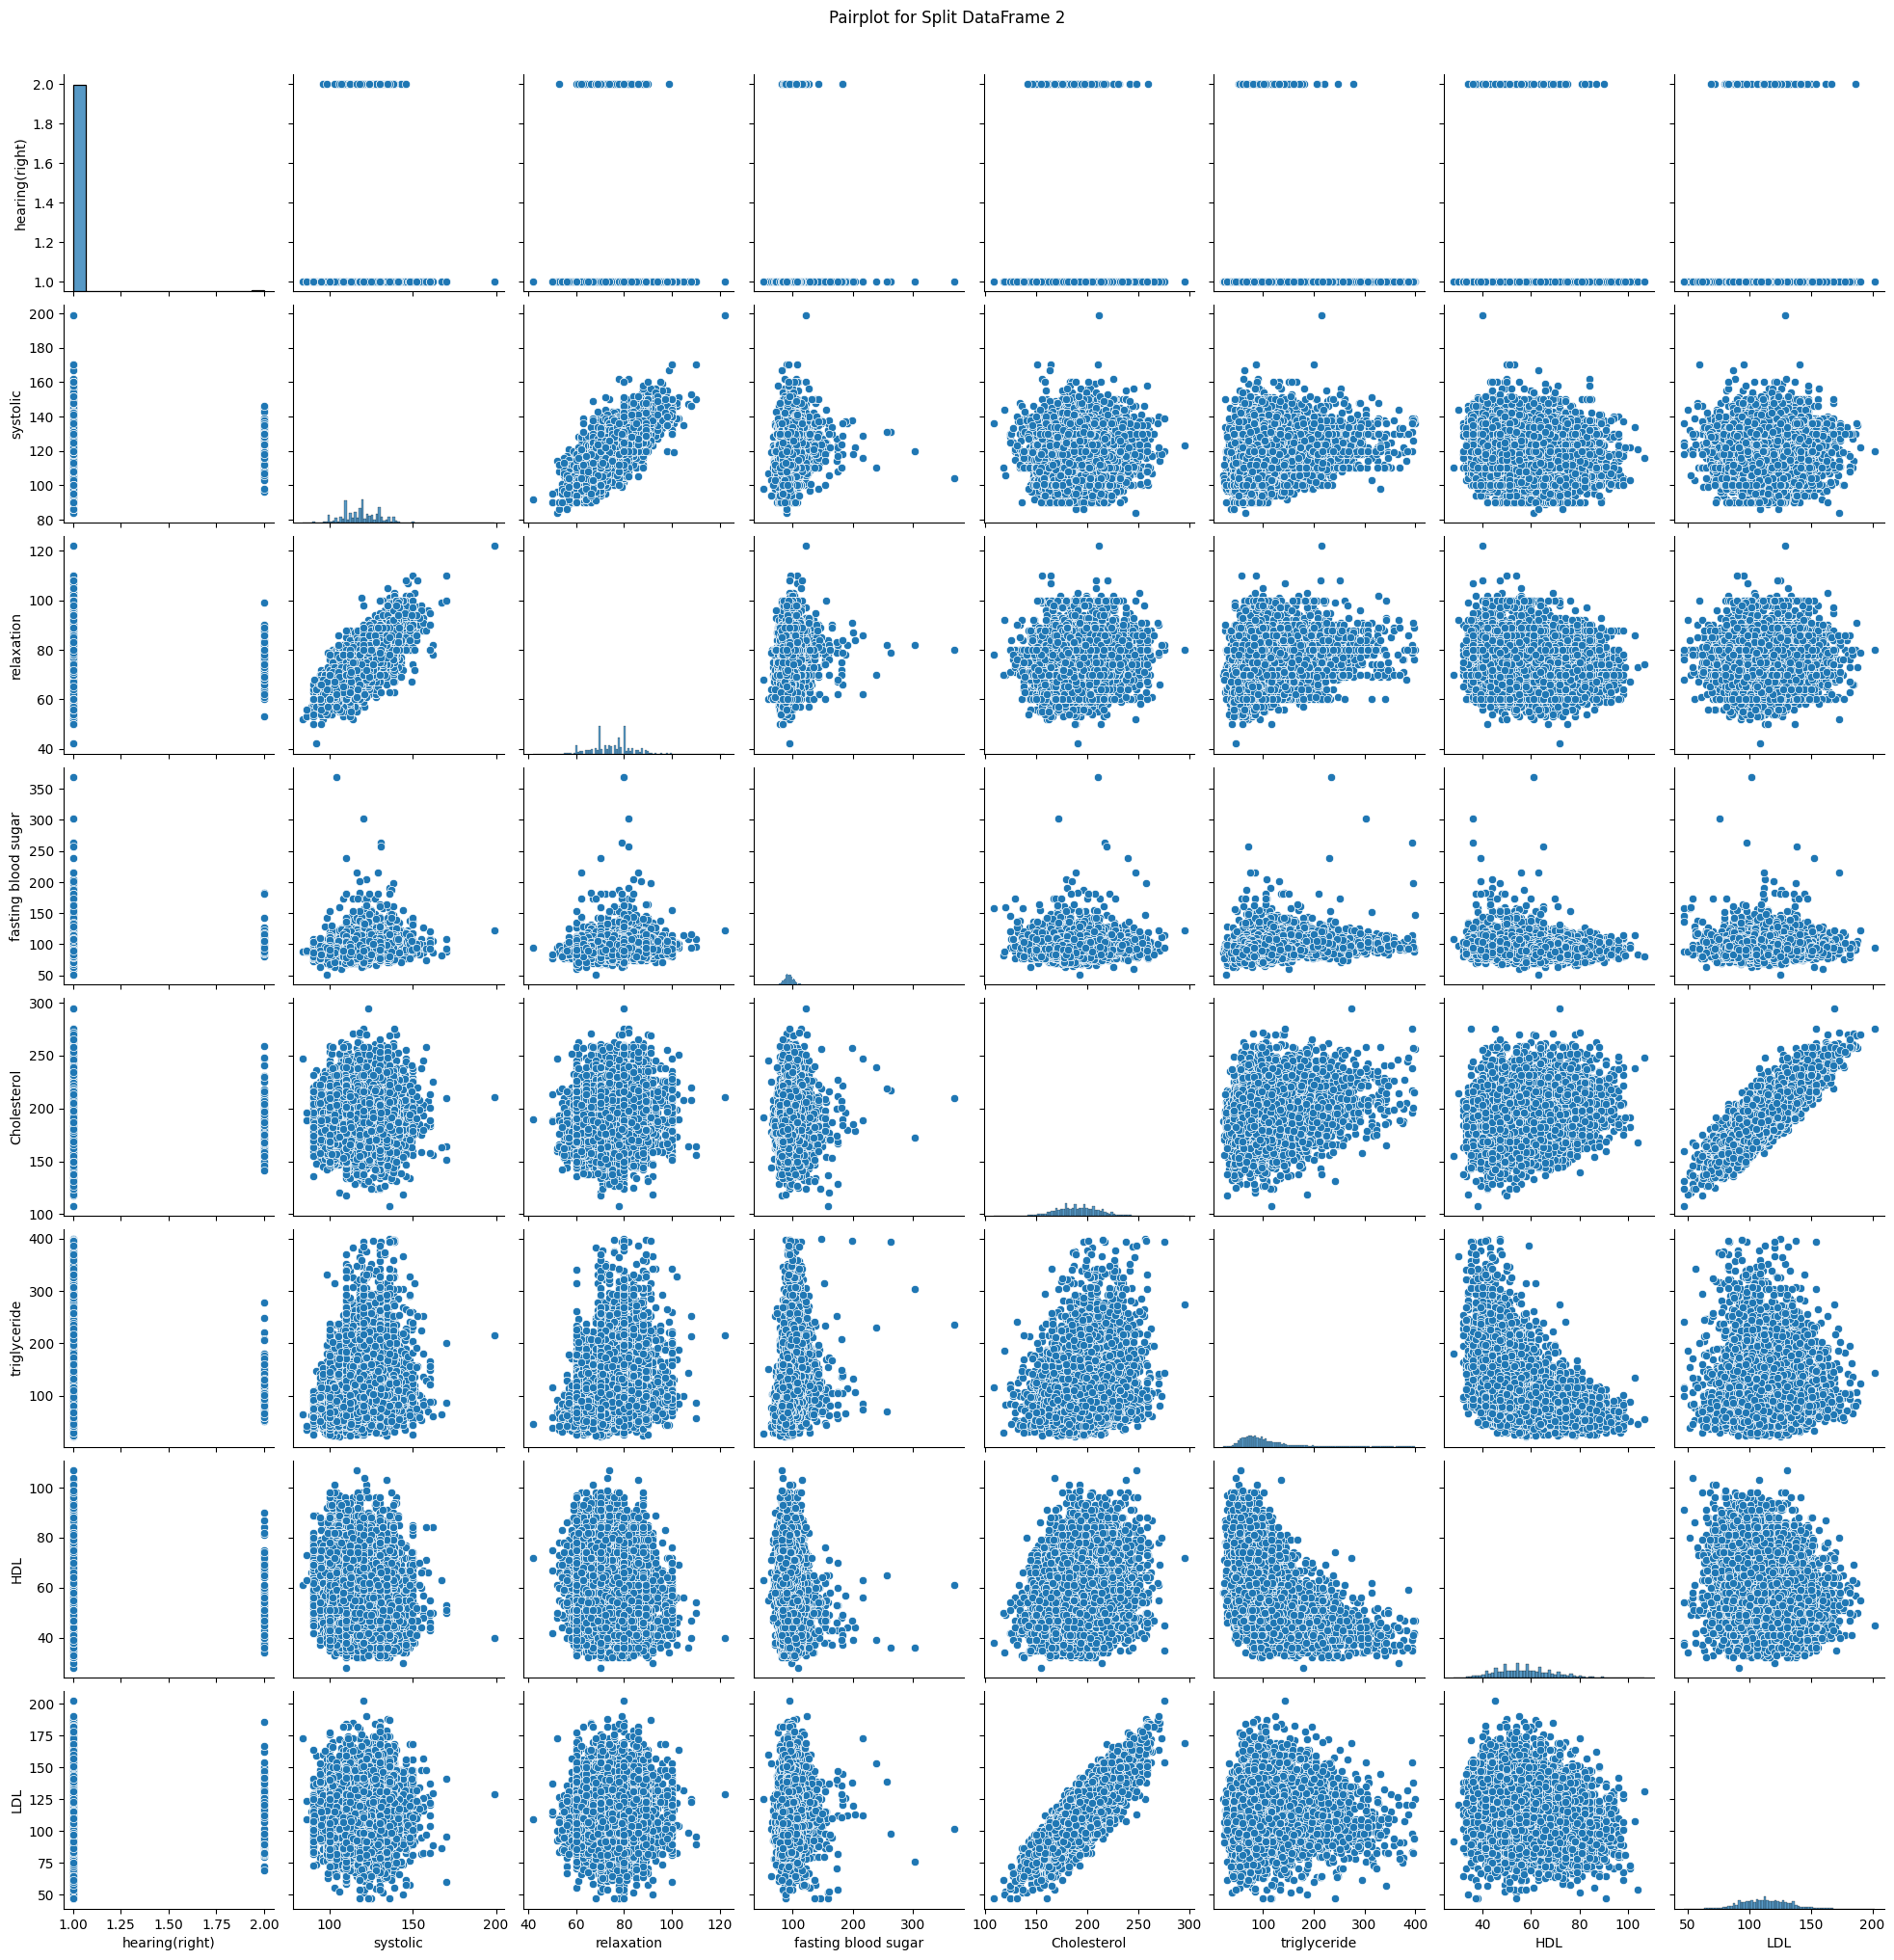

<Figure size 800x600 with 0 Axes>

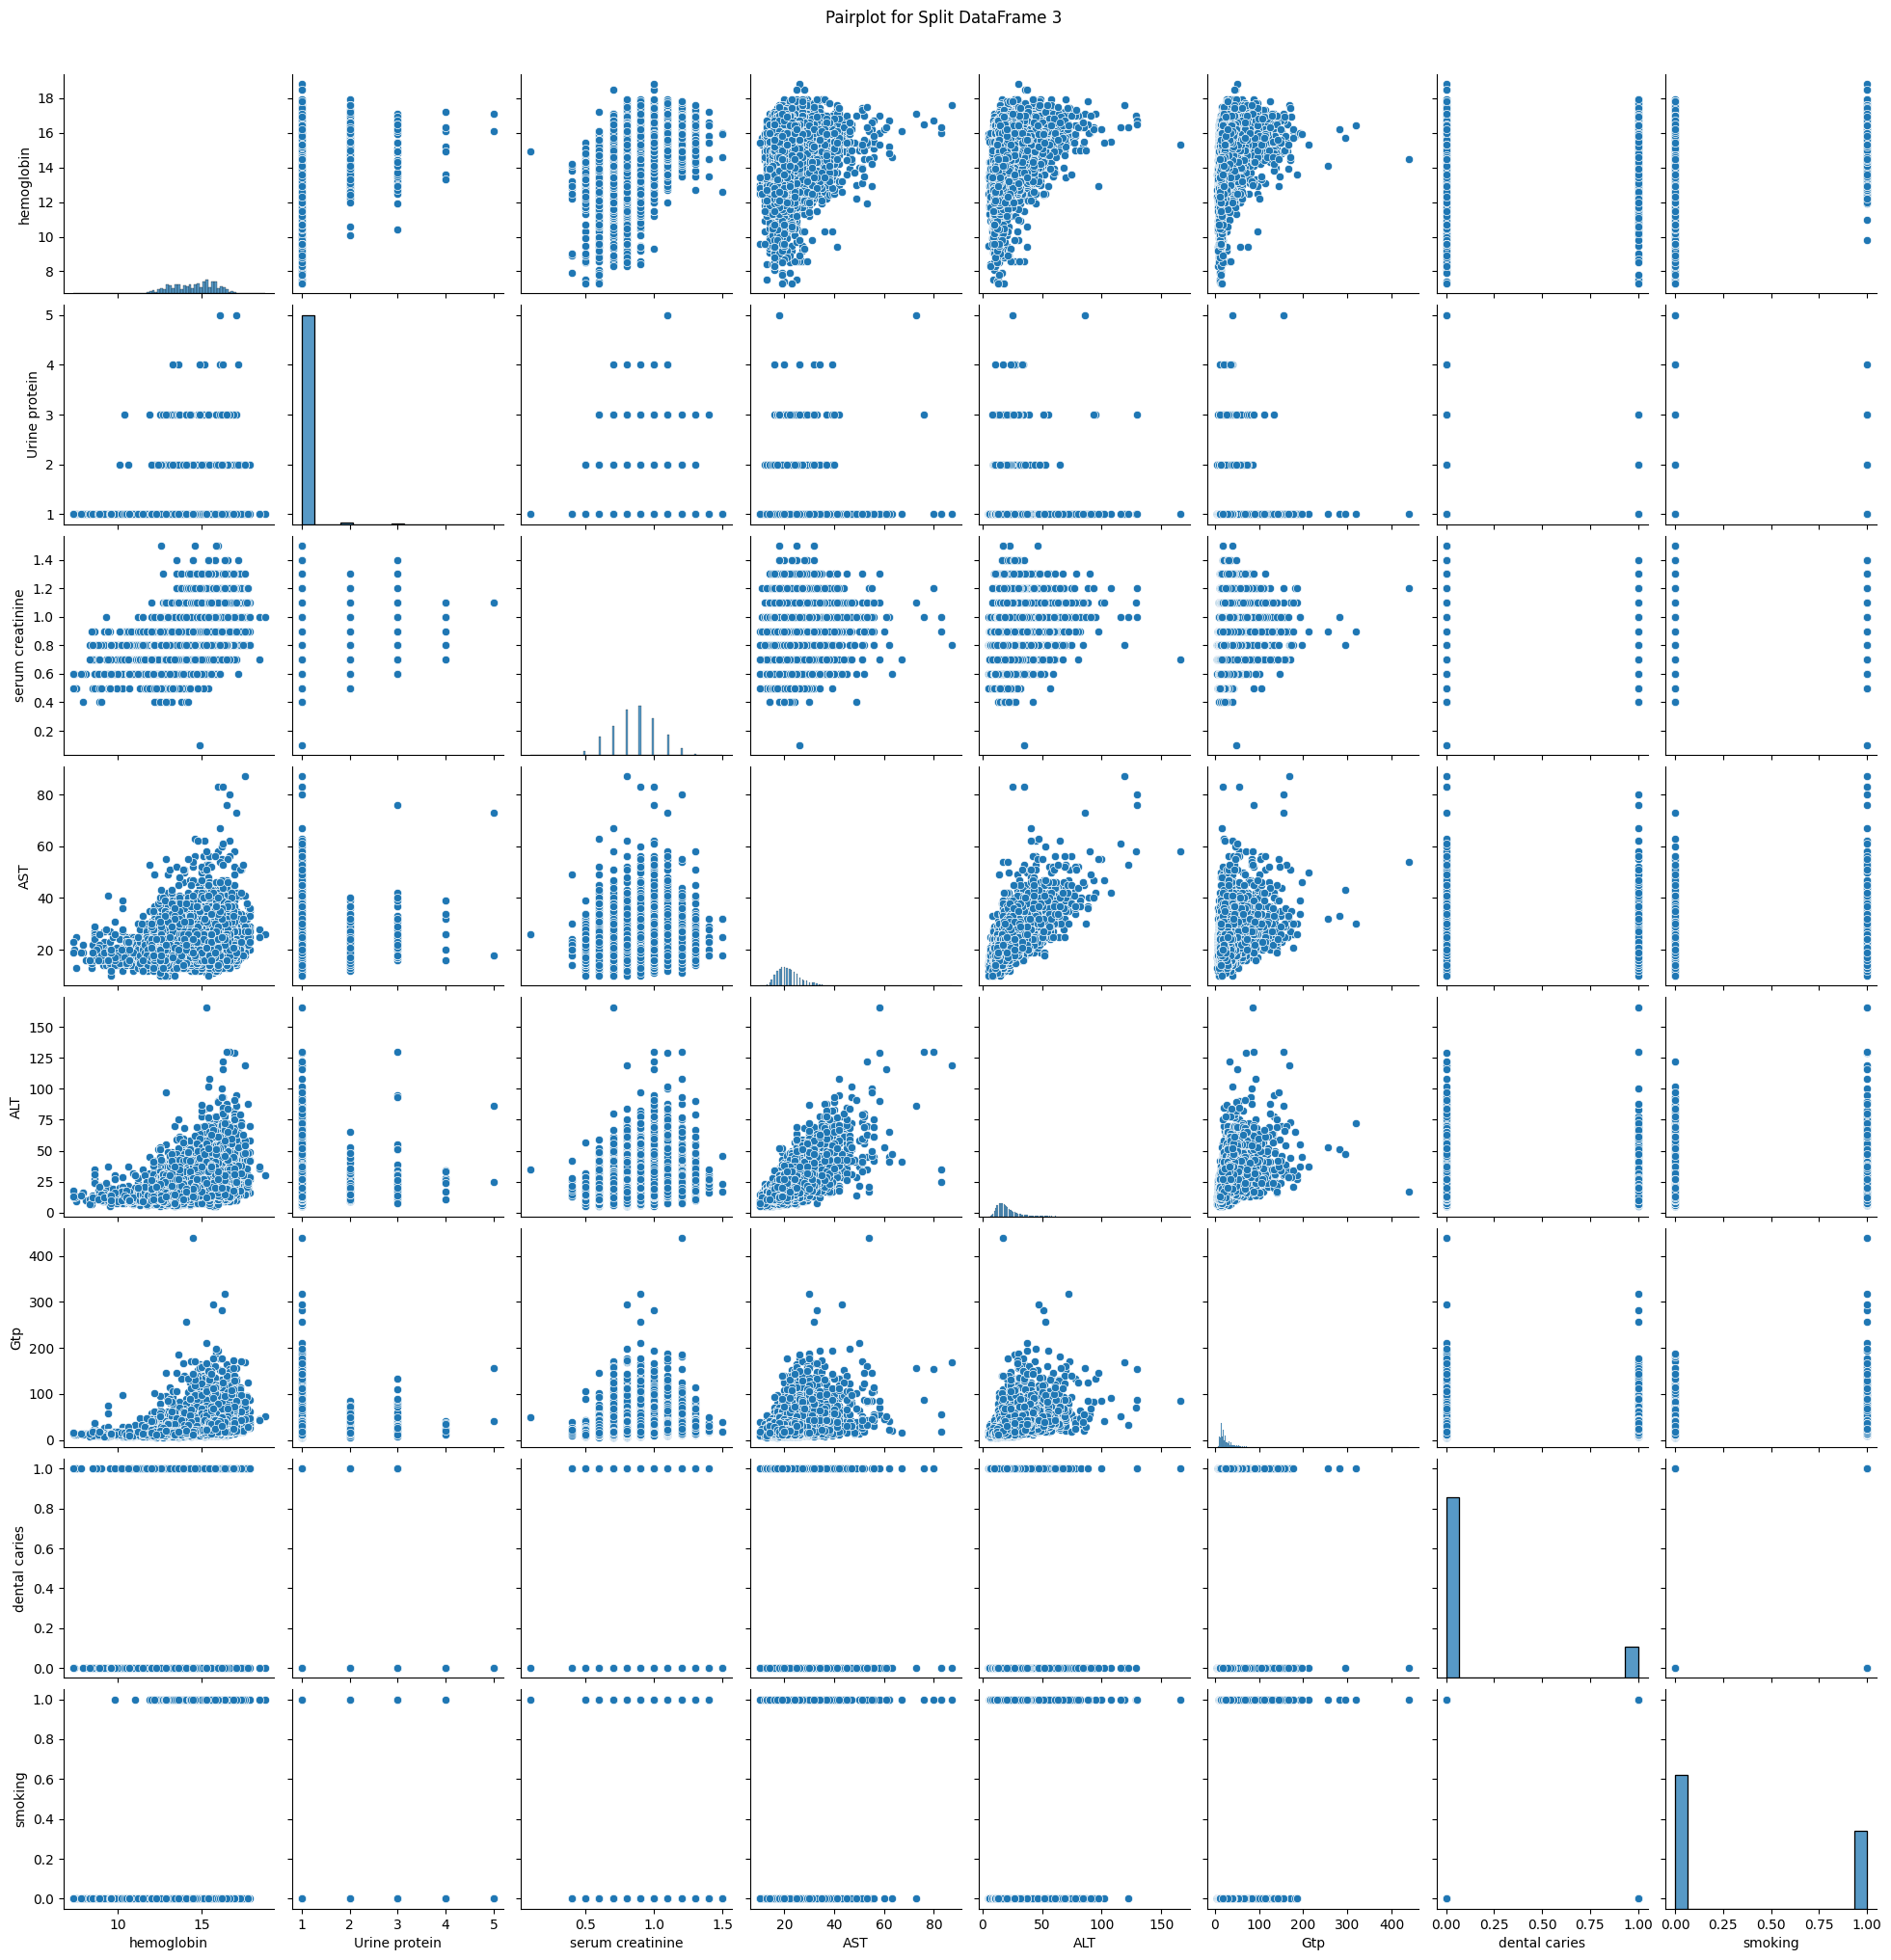

In [6]:
num_splits = 3
split_dfs = np.array_split(data, num_splits, axis=1)
for i, split_df in enumerate(split_dfs):
    plt.figure(figsize=(8, 6))
    sns.pairplot(split_df)
    plt.suptitle(f"Pairplot for Split DataFrame {i + 1}", y=1.02)
    plt.show()

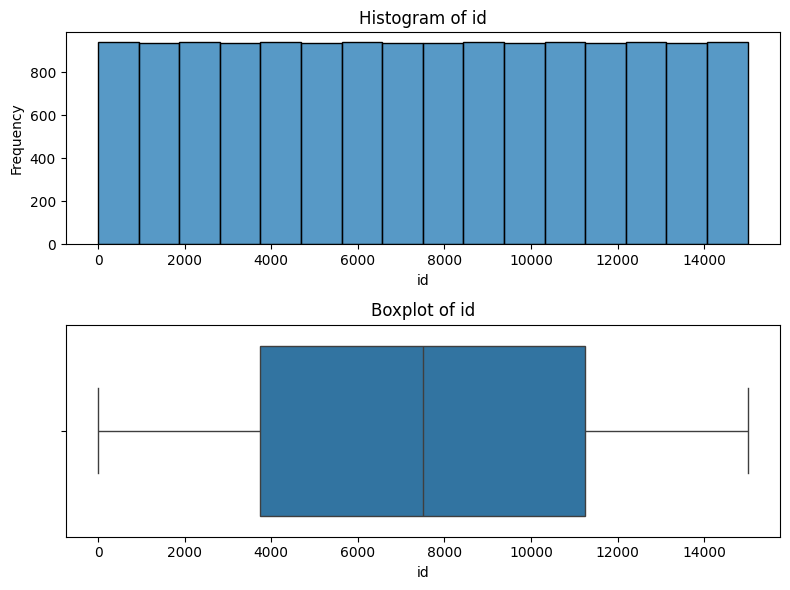

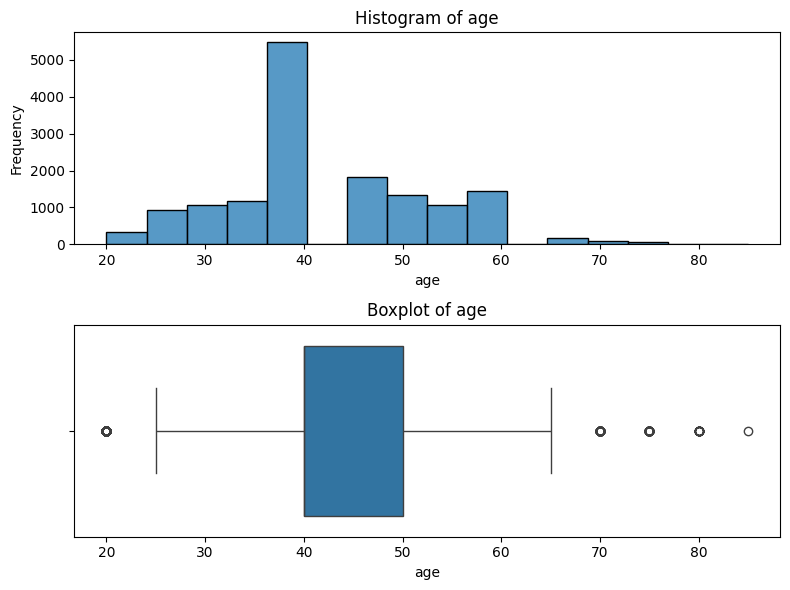

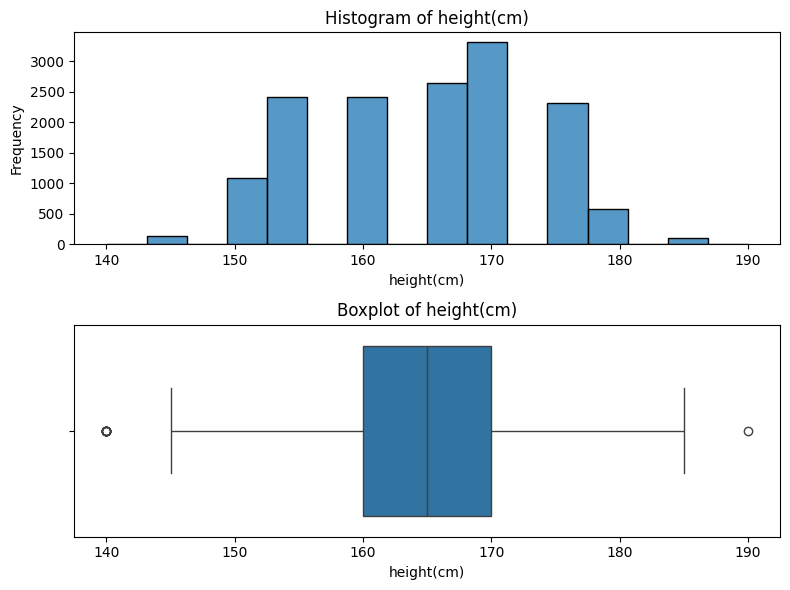

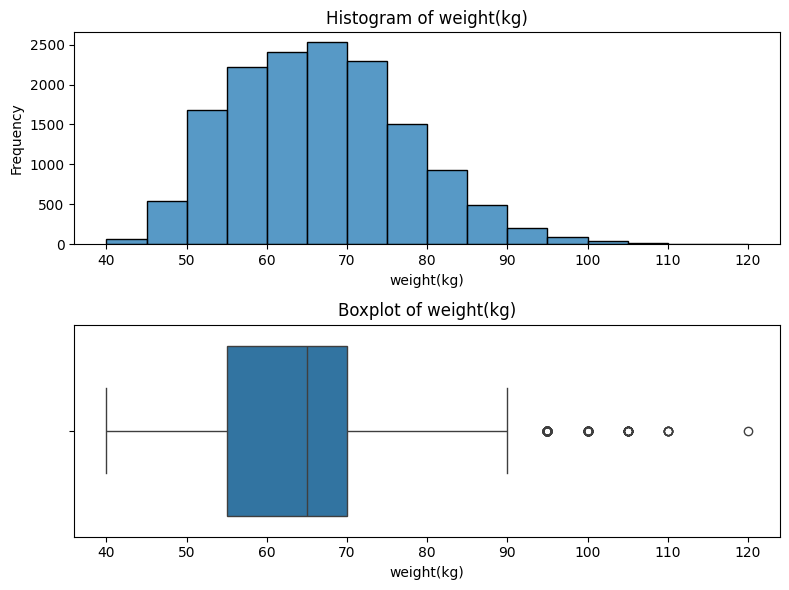

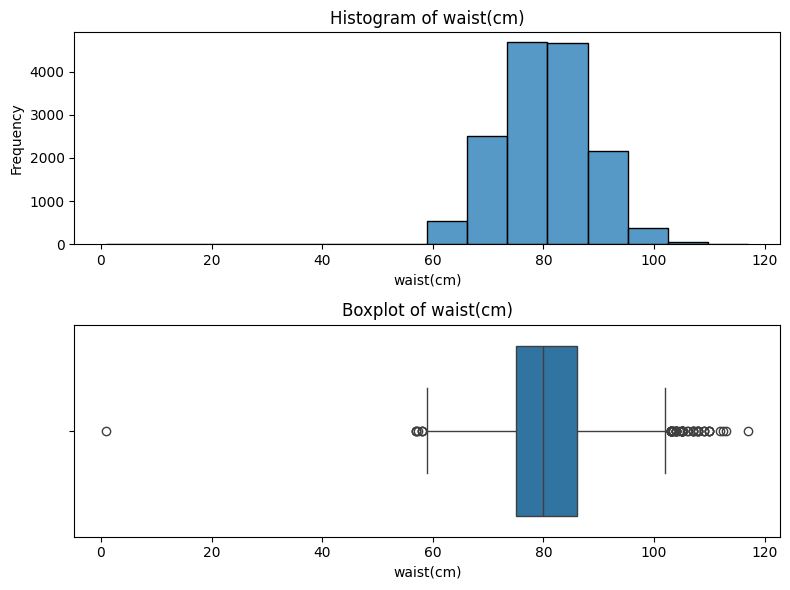

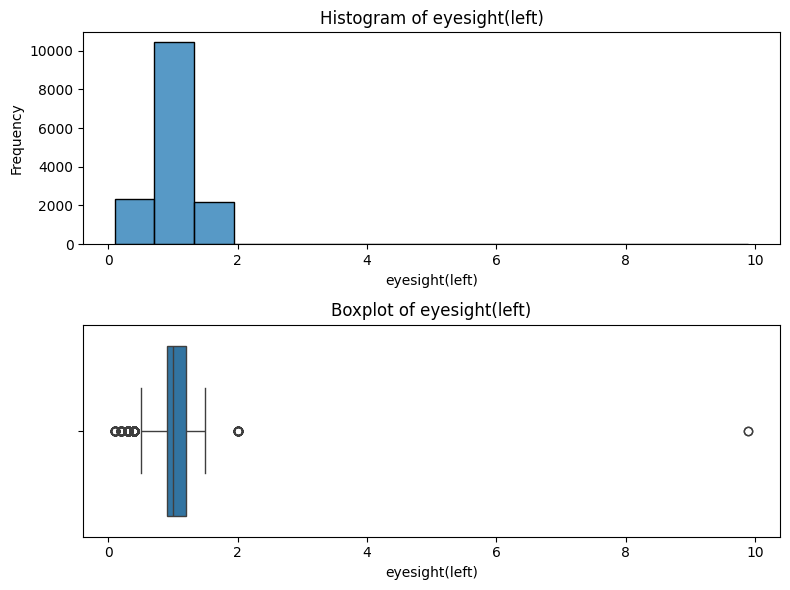

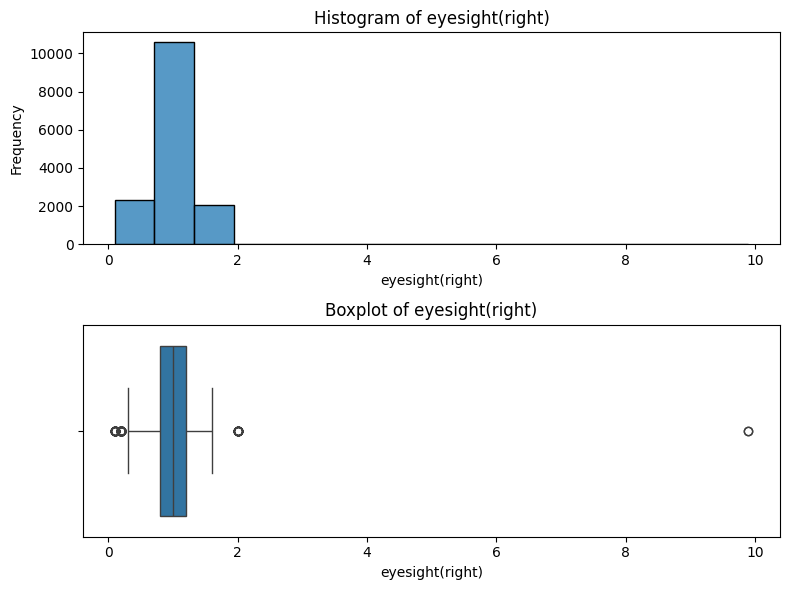

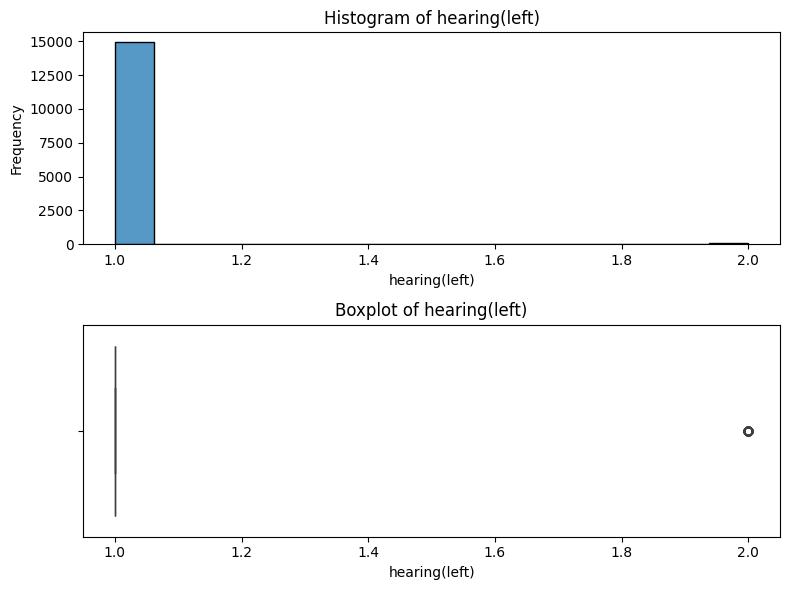

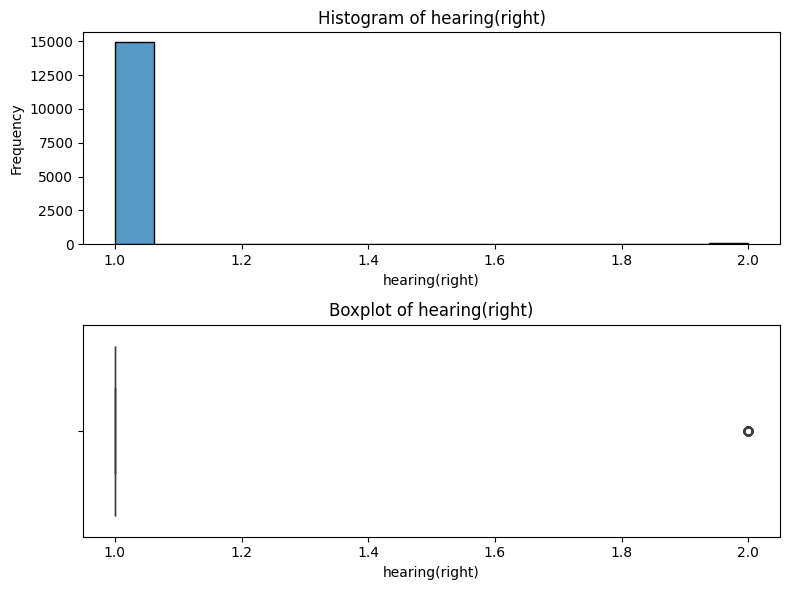

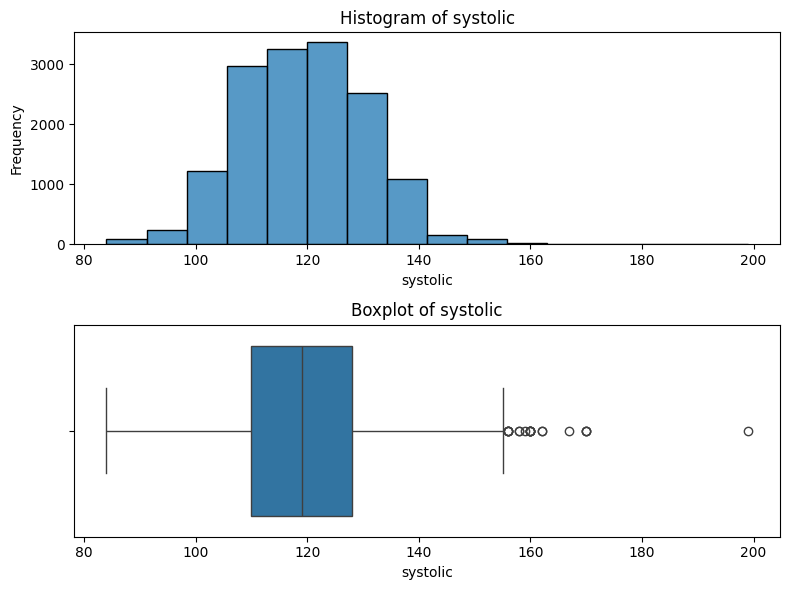

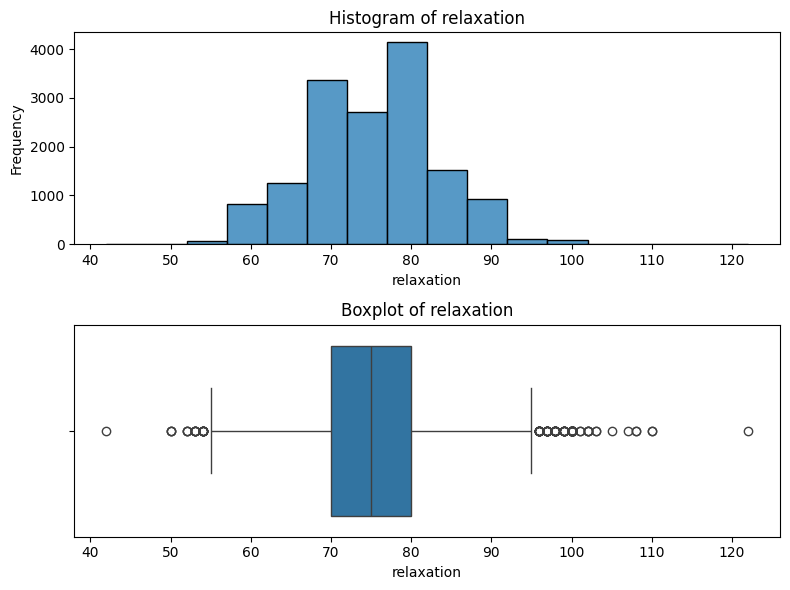

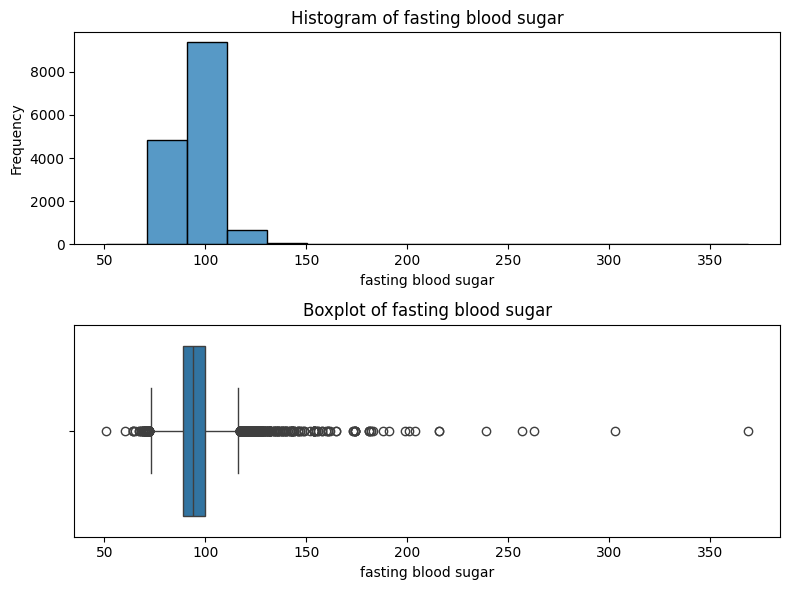

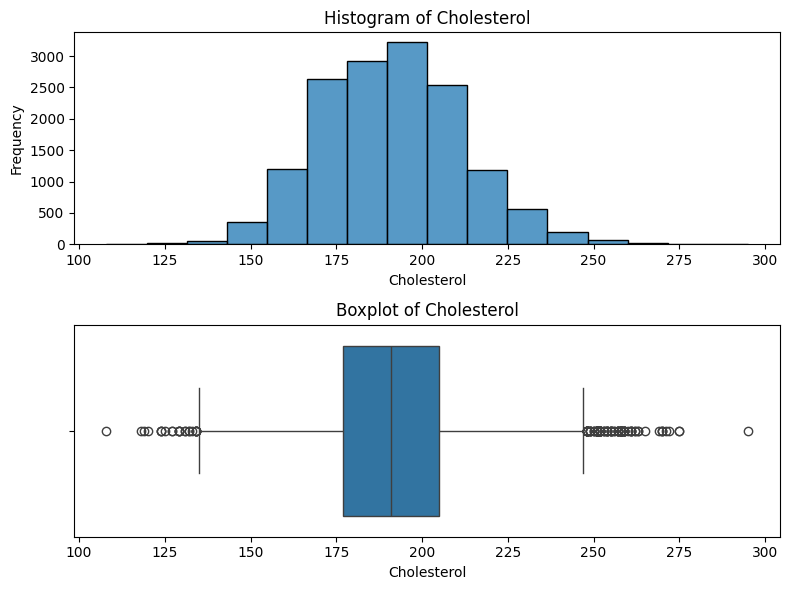

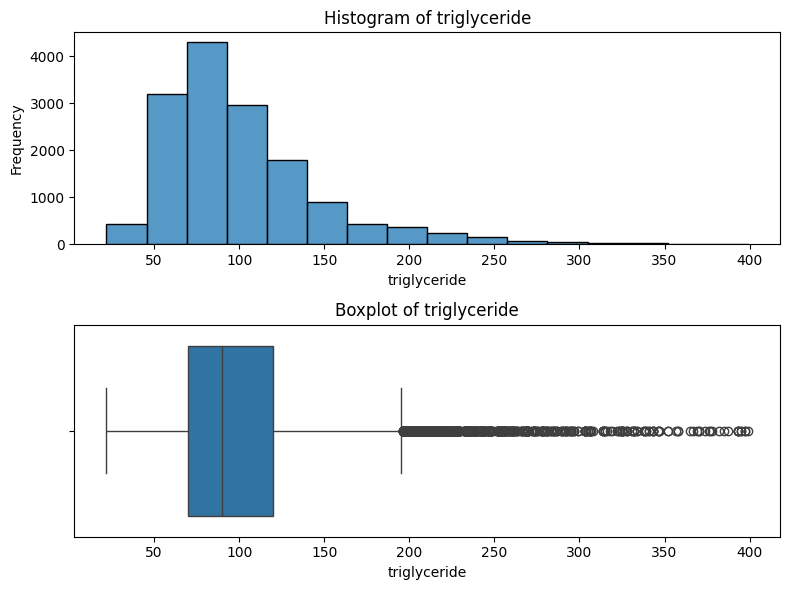

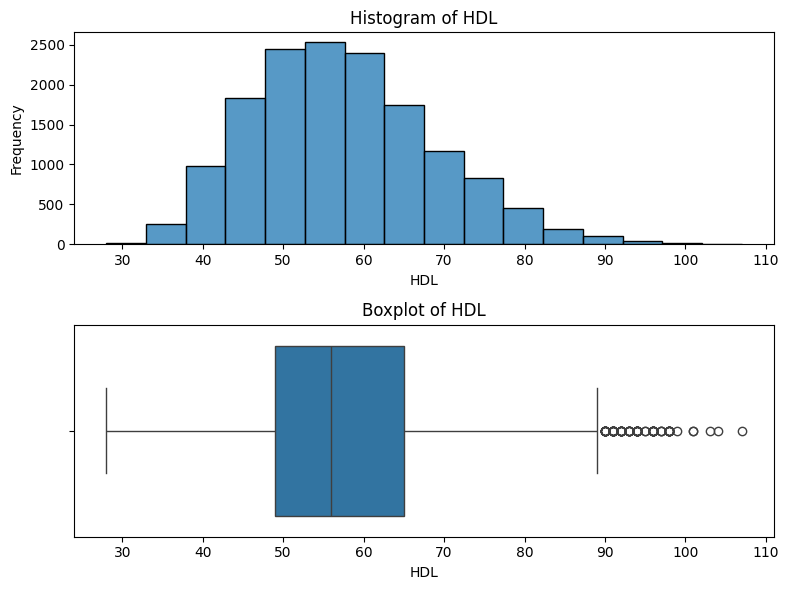

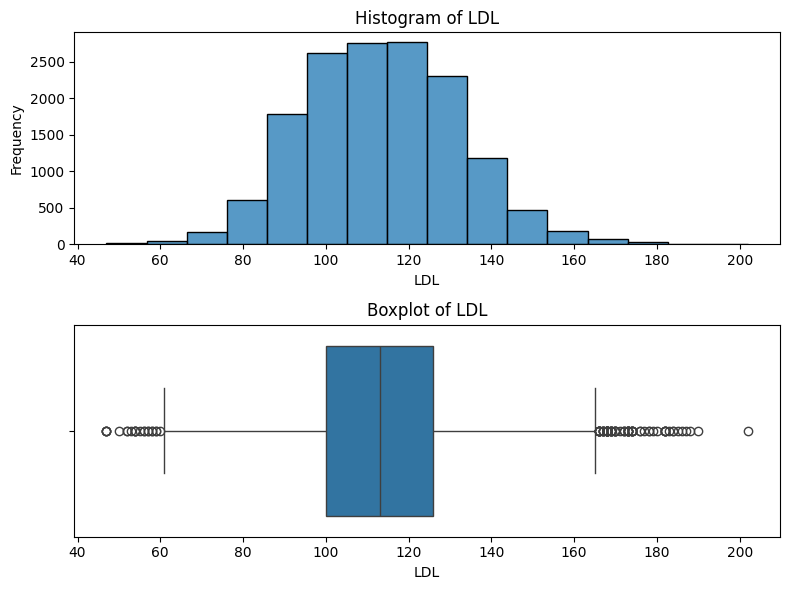

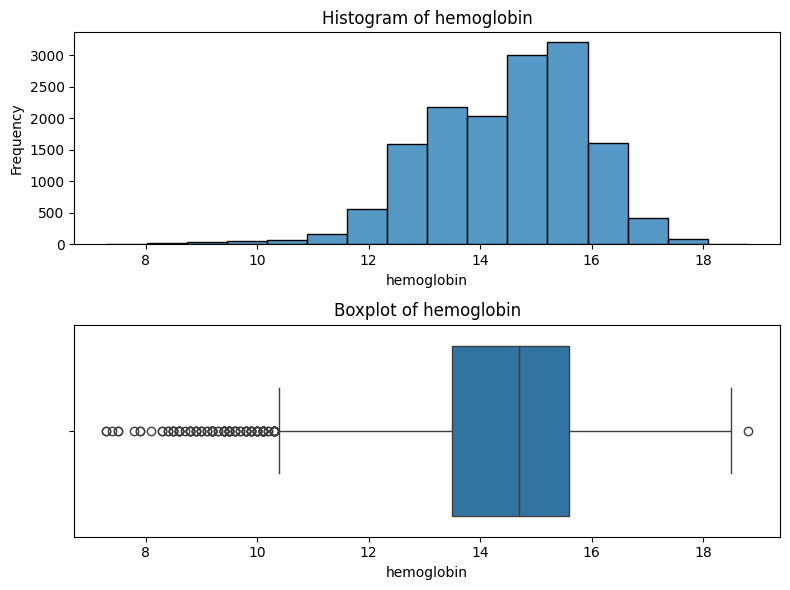

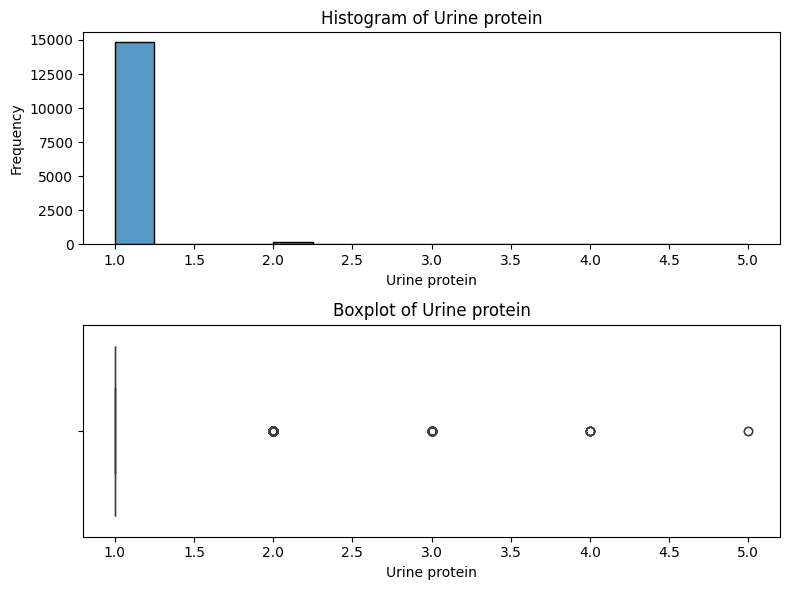

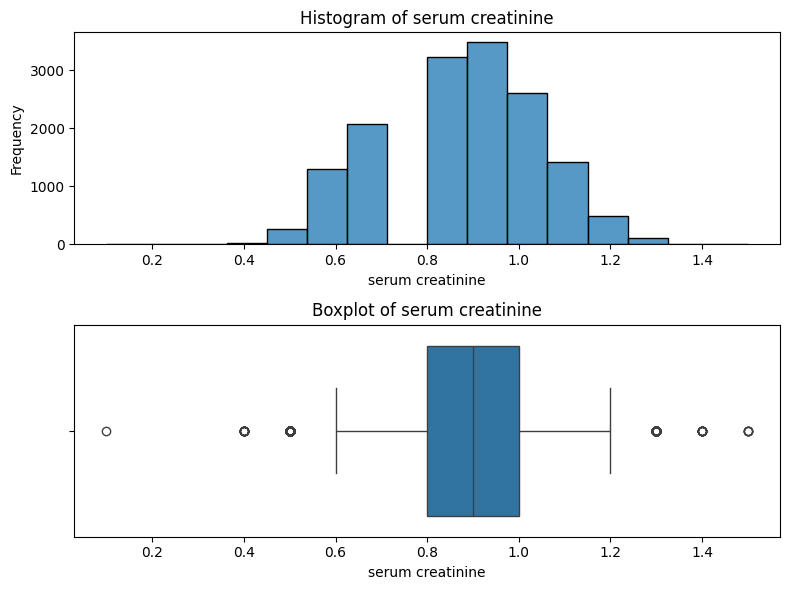

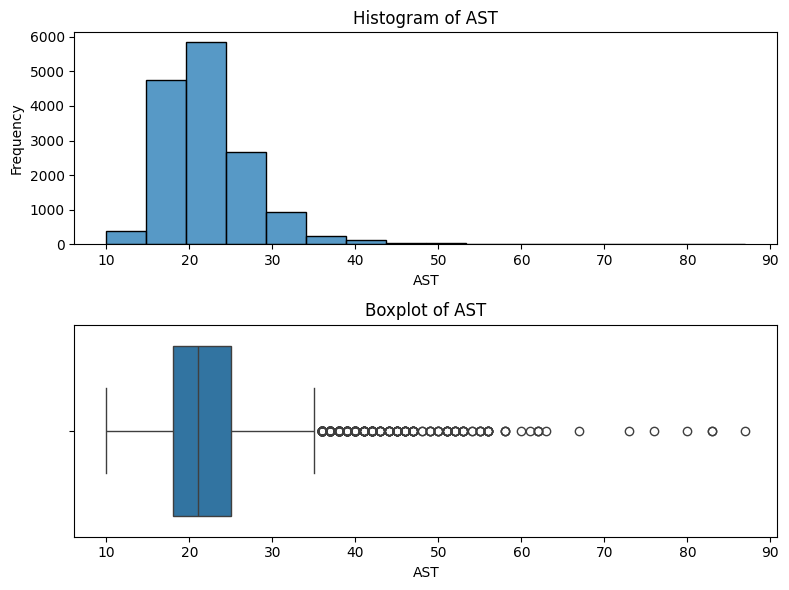

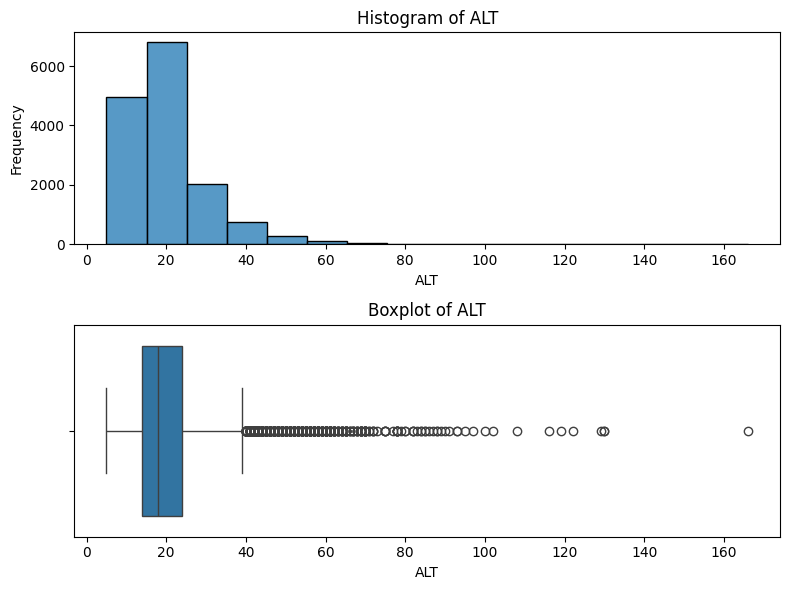

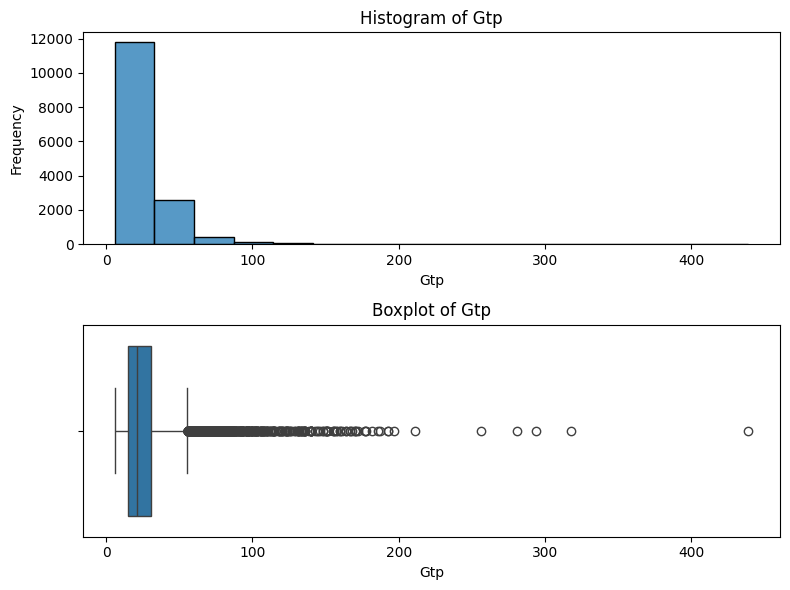

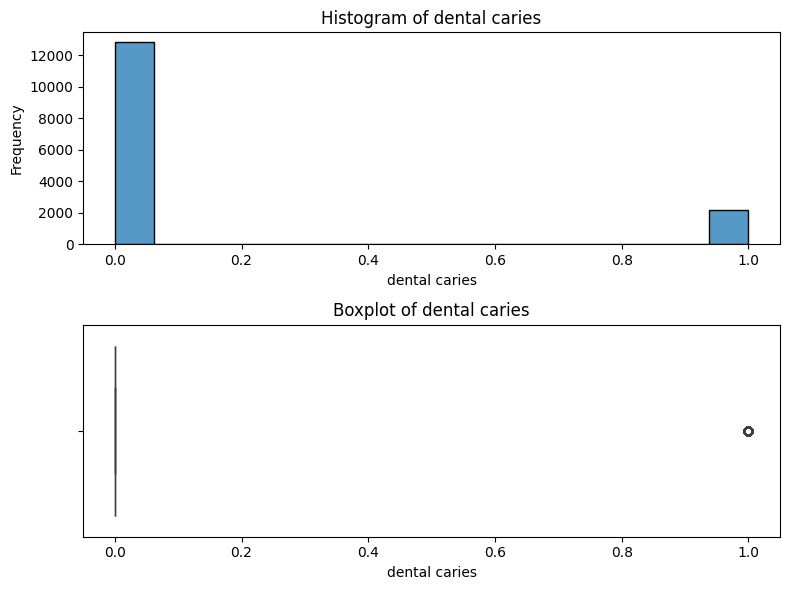

In [7]:
for col in cols:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))  # 2 ta qator va 1 ta ustun

    # Histogram
    sns.histplot(data[col], bins=16, ax=ax1)
    ax1.set_title(f'Histogram of {col}')
    ax1.set_xlabel(col)
    ax1.set_ylabel('Frequency')

    # Boxplot
    sns.boxplot(x=data[col], ax=ax2)
    ax2.set_title(f'Boxplot of {col}')
    ax2.set_xlabel(col)

    plt.tight_layout()  # Bo'shliqlarni to'g'irlash
    plt.show()

## feature engineering

In [8]:
data = fe.feature_engineering(df=data)
print(data.shape)
data.head()

(15000, 28)


id   age  height(cm)  weight(kg)  waist(cm)  systolic  relaxation  \
0   0  55.0       170.0        80.0       92.0     129.0        74.0   
1   1  30.0       170.0        80.0       94.0     128.0        84.0   
2   2  45.0       170.0        75.0       84.0     124.0        80.0   
3   3  55.0       150.0        55.0       85.0     123.0        79.0   
4   4  45.0       160.0        55.0       72.0     117.0        76.0   

   fasting blood sugar  Cholesterol  triglyceride  ...  dental caries  \
0                 82.0        175.0          58.0  ...            0.0   
1                 95.0        188.0         128.0  ...            0.0   
2                 98.0        192.0         138.0  ...            0.0   
3                 95.0        193.0          65.0  ...            0.0   
4                103.0        197.0          81.0  ...            0.0   

   smoking        BMI  BP_Category  Cholesterol_HDL_Ratio  \
0      0.0  27.681661            2               3.571429   
1      1.0  27.681661            3               3.686275   
2      1.0  25.951557            3               3.692308   
3      0.0  24.444444            2               3.163934   
4      0.0  21.484375            1               3.229508   

   Liver_Function_Score  Kidney_Health_Indicator  Combined_Eyesight  \
0                  56.0                 0.058442               1.00   
1                 161.0                 0.055556               1.50   
2                  90.0                 0.061644               1.00   
3                  63.0                 0.059701               0.70   
4                  56.0                 0.050360               0.55   

   Combined_Hearing  TG_HDL_Ratio  
0               1.0      1.183673  
1               1.0      2.509804  
2               1.0      2.653846  
3               1.0      1.065574  
4               1.0      1.327869  

[5 rows x 28 columns]

## woe

### age

smoking   # of non-events  # of events  Percentage events  \
age_cat                                                     
(0, 28]               601          664           0.119921   
(28, 39]              993         1254           0.226476   
(39, 40]             3541         1936           0.349648   
(40, 50]             2180          990           0.178797   
(50, 60]             1856          644           0.116308   
(60, 86]              292           49           0.008850   

smoking   Percentage non-events       WoE        IV  Total Observations  \
age_cat                                                                   
(0, 28]                0.063511  0.635624  0.035856                1265   
(28, 39]               0.104935  0.769300  0.093502                2247   
(39, 40]               0.374194 -0.067849  0.001665                5477   
(40, 50]               0.230371 -0.253439  0.013071                3170   
(50, 60]               0.196132 -0.522544  0.041711                2500   
(60, 86]               0.030857 -1.248997  0.027487                 341   

smoking   Percent of Observations  
age_cat                            
(0, 28]                     8.433  
(28, 39]                   14.980  
(39, 40]                   36.513  
(40, 50]                   21.133  
(50, 60]                   16.667  
(60, 86]                    2.273

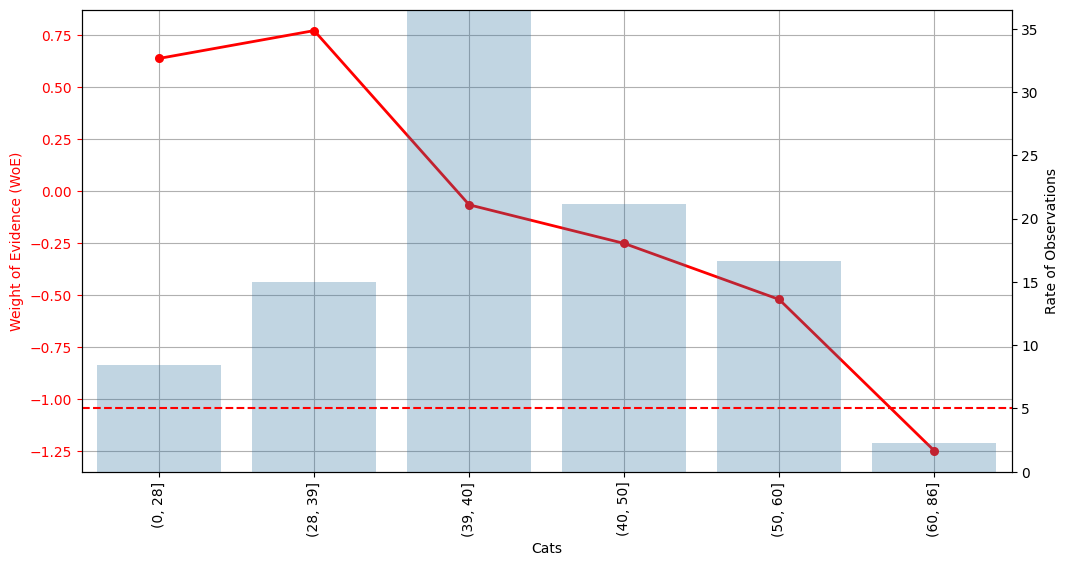

In [9]:
data['age_cat'] = pd.cut(data['age'], bins=[0, 28, 39, 40, 50, 60, 86])
woe_age = woe.WoE(df=data, feature_name='age_cat', target_name='smoking')
woe.plot_woe(woe=woe_age)

### hemoglobin

Sum of IV: 1.919871768719493


smoking         # of non-events  # of events  Percentage events  \
hemoglobin_cat                                                    
(7.0, 12.3]                 873           10           0.001806   
(12.3, 13.0]               1558           33           0.005960   
(13.0, 13.5]               1476           72           0.013003   
(13.5, 13.8]                842           66           0.011920   
(13.8, 14.3]               1065          351           0.063392   
(14.3, 15.4]               2132         2199           0.397146   
(15.4, 16.4]               1262         2232           0.403106   
(16.4, 20.0]                255          574           0.103666   

smoking         Percentage non-events       WoE        IV  Total Observations  \
hemoglobin_cat                                                                  
(7.0, 12.3]                  0.092254 -3.933414  0.355769                 883   
(12.3, 13.0]                 0.164641 -3.318714  0.526618                1591   
(13.0, 13.5]                 0.155976 -2.484488  0.355213                1548   
(13.5, 13.8]                 0.088978 -2.010189  0.154902                 908   
(13.8, 14.3]                 0.112544 -0.574007  0.028214                1416   
(14.3, 15.4]                 0.225299  0.566879  0.097417                4331   
(15.4, 16.4]                 0.133362  1.106137  0.298375                3494   
(16.4, 20.0]                 0.026947  1.347302  0.103364                 829   

smoking         Percent of Observations  
hemoglobin_cat                           
(7.0, 12.3]                       5.887  
(12.3, 13.0]                     10.607  
(13.0, 13.5]                     10.320  
(13.5, 13.8]                      6.053  
(13.8, 14.3]                      9.440  
(14.3, 15.4]                     28.873  
(15.4, 16.4]                     23.293  
(16.4, 20.0]                      5.527

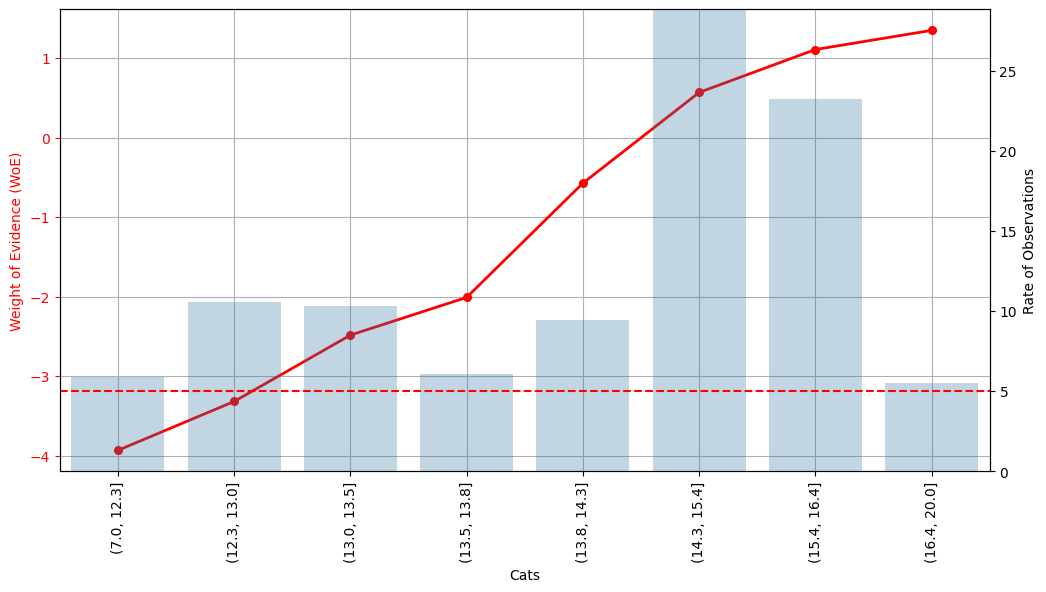

In [10]:
data['hemoglobin_cat'] = pd.cut(data['hemoglobin'], bins=[7, 12.3, 13, 13.5, 13.8, 14.3, 15.4, 16.4, 20])
woe_hemoglobin = woe.WoE(df=data, feature_name='hemoglobin_cat', target_name='smoking')
print("Sum of IV:", woe_hemoglobin['IV'].sum())
woe.plot_woe(woe=woe_hemoglobin)

### height

Sum of IV: 1.7401932648499052


smoking     # of non-events  # of events  Percentage events  \
height_cat                                                    
(130, 150]             1208           20           0.003612   
(150, 155]             2329           83           0.014990   
(155, 164]             2094          316           0.057071   
(164, 200]             3832         5118           0.924327   

smoking     Percentage non-events       WoE        IV  Total Observations  \
height_cat                                                                  
(130, 150]               0.127655 -3.565052  0.442220                1228   
(150, 155]               0.246116 -2.798417  0.646788                2412   
(155, 164]               0.221283 -1.355153  0.222533                2410   
(164, 200]               0.404946  0.825313  0.428653                8950   

smoking     Percent of Observations  
height_cat                           
(130, 150]                    8.187  
(150, 155]                   16.080  
(155, 164]                   16.067  
(164, 200]                   59.667

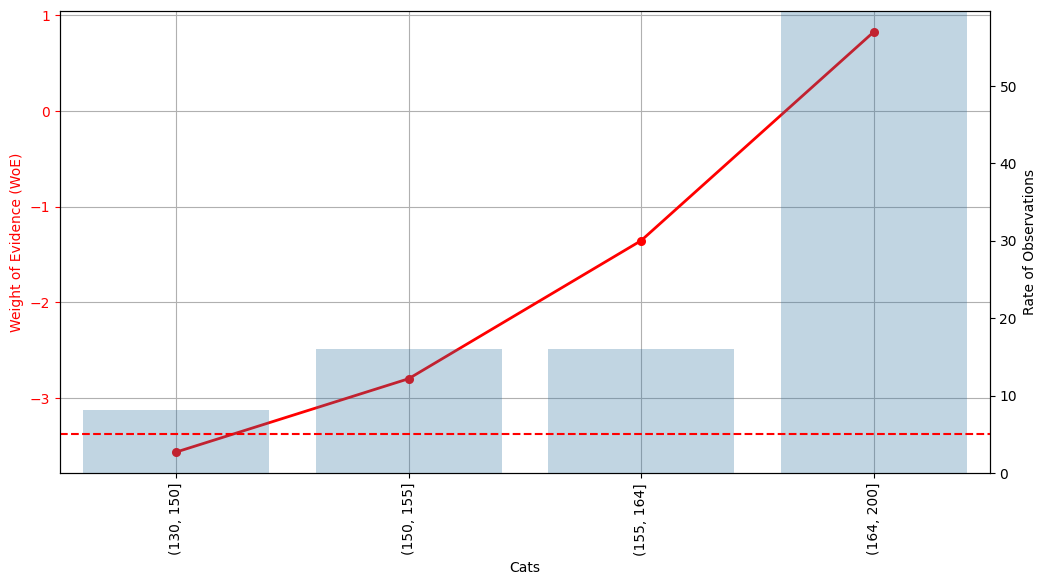

In [11]:
data['height_cat'] = pd.cut(data['height(cm)'], bins=[130, 150, 155, 164, 200])
woe_height = woe.WoE(df=data, feature_name='height_cat', target_name='smoking')
print('Sum of IV:', woe_height['IV'].sum())
woe.plot_woe(woe=woe_height)

### weight

Sum of IV: 0.9629799837466461


smoking     # of non-events  # of events  Percentage events  \
weight_cat                                                    
1                      2151          136           0.024562   
2                      1870          344           0.062128   
3                      1736          666           0.120282   
4                      1383         1144           0.206610   
5                      1054         1236           0.223226   
6                       611          891           0.160917   
7                       658         1120           0.202276   

smoking     Percentage non-events       WoE        IV  Total Observations  \
weight_cat                                                                  
1                        0.227306 -2.225097  0.451126                2287   
2                        0.197612 -1.157115  0.156771                2214   
3                        0.183451 -0.422113  0.026665                2402   
4                        0.146148  0.346212  0.020933                2527   
5                        0.111381  0.695225  0.077757                2290   
6                        0.064567  0.913184  0.087985                1502   
7                        0.069534  1.067816  0.141744                1778   

smoking     Percent of Observations  
weight_cat                           
1                            15.247  
2                            14.760  
3                            16.013  
4                            16.847  
5                            15.267  
6                            10.013  
7                            11.853

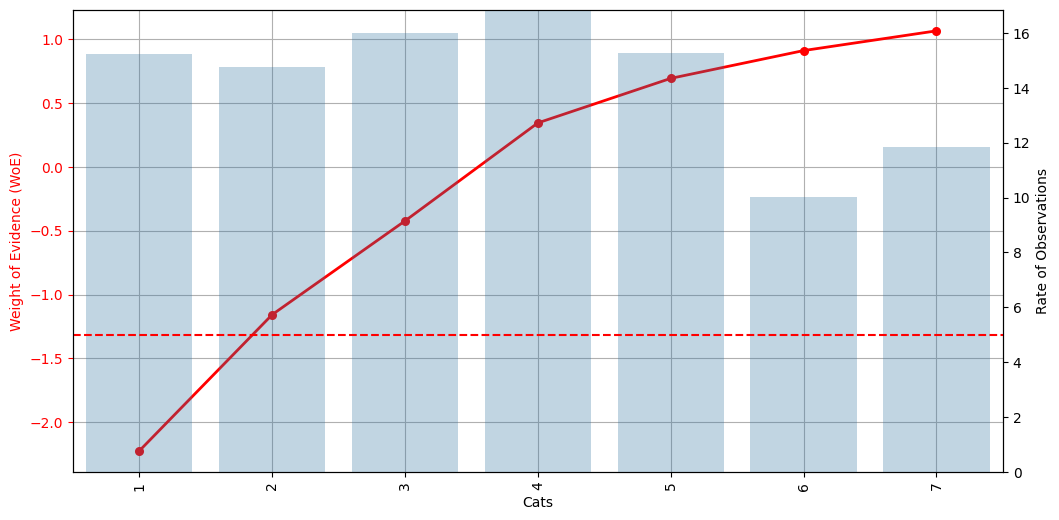

In [12]:
data['weight_cat'] = pd.qcut(data['weight(kg)'], q=7, labels=list(range(1, 8)))
woe_height = woe.WoE(df=data, feature_name='weight_cat', target_name='smoking')
print('Sum of IV:', woe_height['IV'].sum())
woe.plot_woe(woe=woe_height)

### triglyceride

Sum of IV: 0.6533096816908657


smoking           # of non-events  # of events  Percentage events  \
triglyceride_cat                                                    
(21.999, 59.0]               1744          229           0.041358   
(59.0, 70.0]                 1460          371           0.067004   
(70.0, 80.0]                 1421          469           0.084703   
(80.0, 90.0]                 1365          531           0.095900   
(90.0, 103.0]                1076          749           0.135272   
(103.0, 120.0]                959          902           0.162904   
(120.0, 149.0]                829         1047           0.189092   
(149.0, 399.0]                609         1239           0.223767   

smoking           Percentage non-events       WoE        IV  \
triglyceride_cat                                              
(21.999, 59.0]                 0.184297 -1.494278  0.213590   
(59.0, 70.0]                   0.154285 -0.834053  0.072797   
(70.0, 80.0]                   0.150164 -0.572577  0.037481   
(80.0, 90.0]                   0.144246 -0.408211  0.019735   
(90.0, 103.0]                  0.113706  0.173670  0.003745   
(103.0, 120.0]                 0.101342  0.474660  0.029221   
(120.0, 149.0]                 0.087604  0.769401  0.078084   
(149.0, 399.0]                 0.064356  1.246178  0.198655   

smoking           Total Observations  Percent of Observations  
triglyceride_cat                                               
(21.999, 59.0]                  1973                   13.153  
(59.0, 70.0]                    1831                   12.207  
(70.0, 80.0]                    1890                   12.600  
(80.0, 90.0]                    1896                   12.640  
(90.0, 103.0]                   1825                   12.167  
(103.0, 120.0]                  1861                   12.407  
(120.0, 149.0]                  1876                   12.507  
(149.0, 399.0]                  1848                   12.320

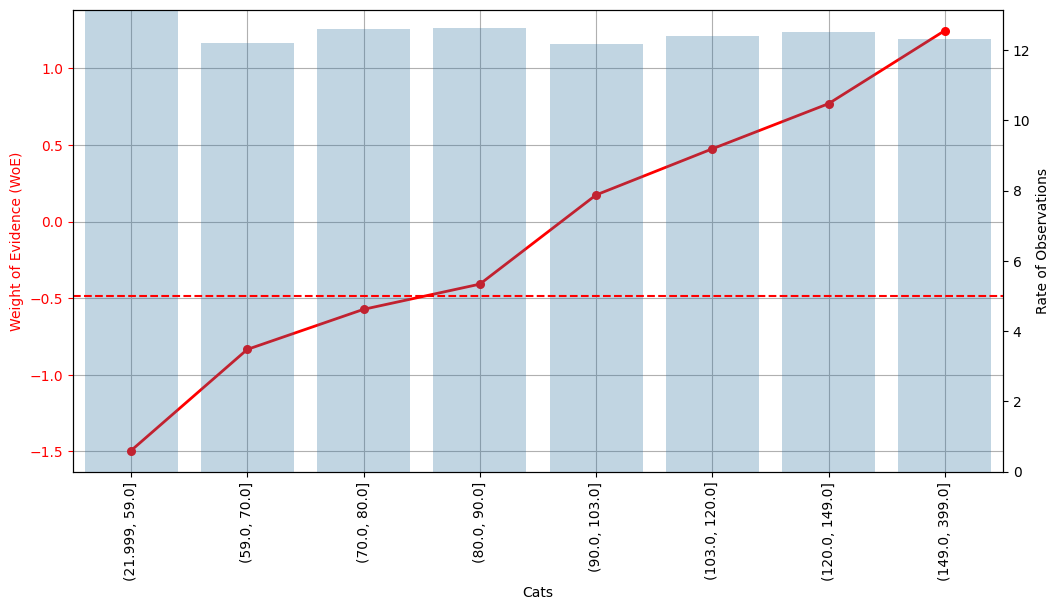

In [13]:
data['triglyceride_cat'] = pd.qcut(data['triglyceride'], q=8)
woe_triglyceride = woe.WoE(df=data, feature_name='triglyceride_cat', target_name='smoking')
print("Sum of IV:", woe_triglyceride['IV'].sum())
woe.plot_woe(woe=woe_triglyceride)

### HDL

Sum of IV: 0.39424229427125146


smoking    # of non-events  # of events  Percentage events  \
hdl_cat                                                      
(0, 40]                254          499           0.090121   
(40, 50]              1755         2005           0.362109   
(50, 57]              2164         1382           0.249594   
(57, 70]              3568         1310           0.236590   
(70, 75]               818          182           0.032870   
(75, 110]              904          159           0.028716   

smoking    Percentage non-events       WoE        IV  Total Observations  \
hdl_cat                                                                    
(0, 40]                 0.026841  1.211208  0.076645                 753   
(40, 50]                0.185459  0.669112  0.118199                3760   
(50, 57]                0.228680  0.087510  0.001830                3546   
(57, 70]                0.377047 -0.466041  0.065459                4878   
(70, 75]                0.086442 -0.966919  0.051800                1000   
(75, 110]               0.095530 -1.201989  0.080310                1063   

smoking    Percent of Observations  
hdl_cat                             
(0, 40]                      5.020  
(40, 50]                    25.067  
(50, 57]                    23.640  
(57, 70]                    32.520  
(70, 75]                     6.667  
(75, 110]                    7.087

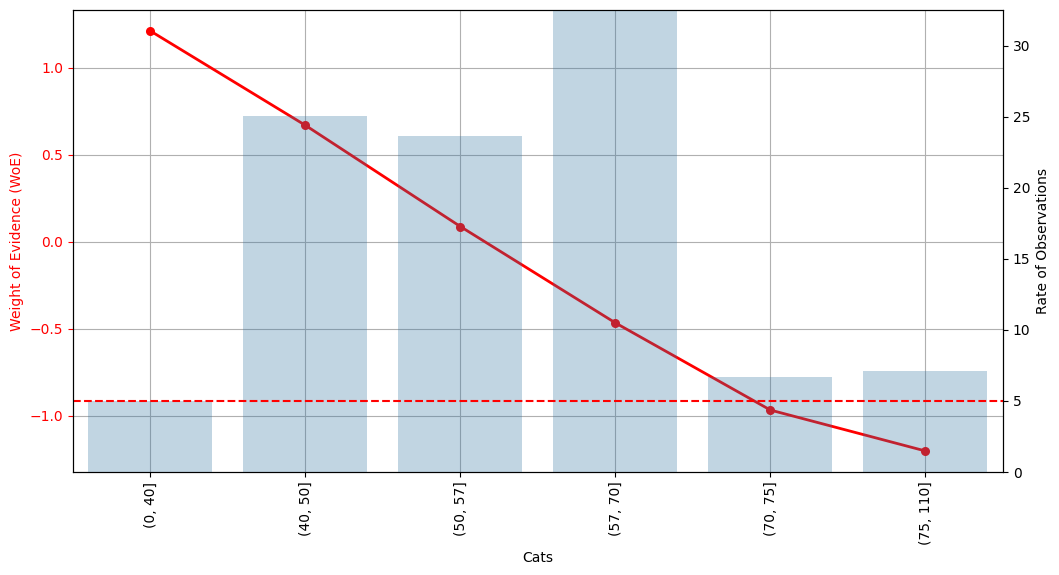

In [14]:
data['hdl_cat'] = pd.cut(data['HDL'], bins=[0, 40, 50, 57, 70, 75, 110])
woe_hdl = woe.WoE(df=data, feature_name='hdl_cat', target_name='smoking')
print("Sum of IV:", woe_hdl['IV'].sum())
woe.plot_woe(woe=woe_hdl)

### TG_HDL_Ratio

Sum of IV: 0.7253338211734267


smoking  # of non-events  # of events  Percentage events  \
thr_cat                                                    
1                   1048          108           0.019505   
2                    980          143           0.025826   
3                   2375          631           0.113961   
4                   1201          479           0.086509   
5                    860          474           0.085606   
6                   1123          887           0.160195   
7                    674          746           0.134730   
8                    708         1000           0.180603   
9                    368          703           0.126964   
10                   126          366           0.066101   

smoking  Percentage non-events       WoE        IV  Total Observations  \
thr_cat                                                                  
1                     0.110747 -1.736571  0.158448                1156   
2                     0.103561 -1.388771  0.107956                1123   
3                     0.250977 -0.789510  0.108176                3006   
4                     0.126915 -0.383273  0.015487                1680   
5                     0.090880 -0.059788  0.000315                1334   
6                     0.118673  0.300023  0.012458                2010   
7                     0.071225  0.637432  0.040480                1420   
8                     0.074818  0.881248  0.093223                1708   
9                     0.038888  1.183211  0.104212                1071   
10                    0.013315  1.602288  0.084578                 492   

smoking  Percent of Observations  
thr_cat                           
1                          7.707  
2                          7.487  
3                         20.040  
4                         11.200  
5                          8.893  
6                         13.400  
7                          9.467  
8                         11.387  
9                          7.140  
10                         3.280

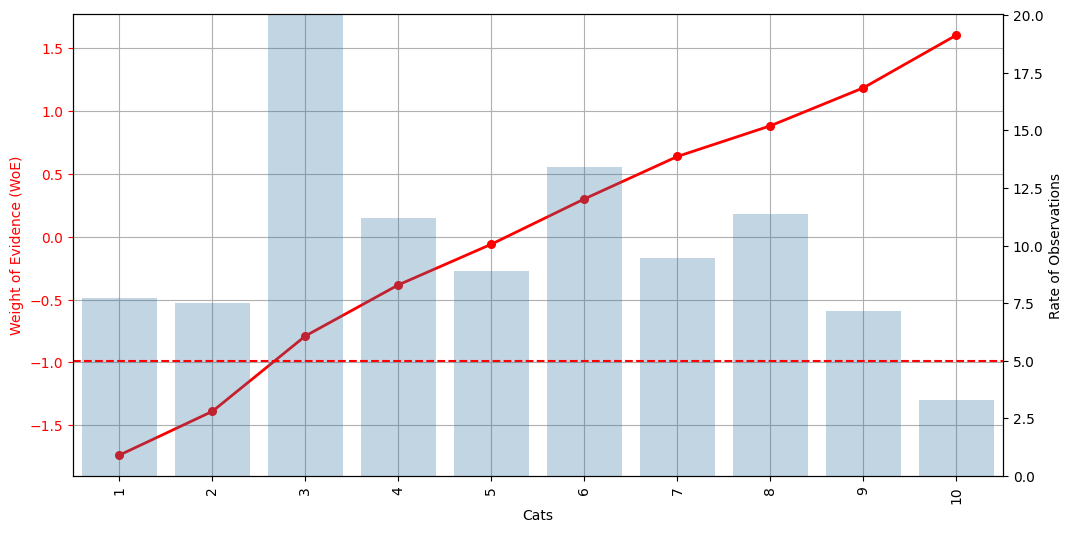

In [15]:
data['thr_cat'] = pd.cut(data['TG_HDL_Ratio'], bins=[0, .8, 0.95, 1.3, 1.5, 1.7, 2.1, 2.5, 3.4, 5, 13], labels=list(range(1, 11)))
woe_hdl2 = woe.WoE(df=data, feature_name='thr_cat', target_name='smoking')
print("Sum of IV:", woe_hdl2['IV'].sum())
woe.plot_woe(woe=woe_hdl2)

### Liver function score

Sum of IV: 0.7205645230821165


smoking     # of non-events  # of events  Percentage events  \
lfs_cat                                                       
(23, 42]               1107          103           0.018602   
(42, 47]               1319          228           0.041178   
(47, 51]               1070          278           0.050208   
(51, 55]               1054          346           0.062489   
(55, 62]               1533          699           0.126242   
(62, 70]               1166          792           0.143038   
(70, 80]                870          827           0.149359   
(80, 90]                491          616           0.111252   
(90, 110]               504          810           0.146289   
(110, 511]              349          838           0.151345   

smoking     Percentage non-events       WoE        IV  Total Observations  \
lfs_cat                                                                     
(23, 42]                 0.116982 -1.838743  0.180895                1210   
(42, 47]                 0.139385 -1.219347  0.119749                1547   
(47, 51]                 0.113072 -0.811856  0.051037                1348   
(51, 55]                 0.111381 -0.577972  0.028258                1400   
(55, 62]                 0.161999 -0.249395  0.008918                2232   
(62, 70]                 0.123217  0.149164  0.002957                1958   
(70, 80]                 0.091937  0.485248  0.027864                1697   
(80, 90]                 0.051886  0.762739  0.045280                1107   
(90, 110]                0.053260  1.010395  0.093996                1314   
(110, 511]               0.036880  1.411883  0.161611                1187   

smoking     Percent of Observations  
lfs_cat                              
(23, 42]                      8.067  
(42, 47]                     10.313  
(47, 51]                      8.987  
(51, 55]                      9.333  
(55, 62]                     14.880  
(62, 70]                     13.053  
(70, 80]                     11.313  
(80, 90]                      7.380  
(90, 110]                     8.760  
(110, 511]                    7.913

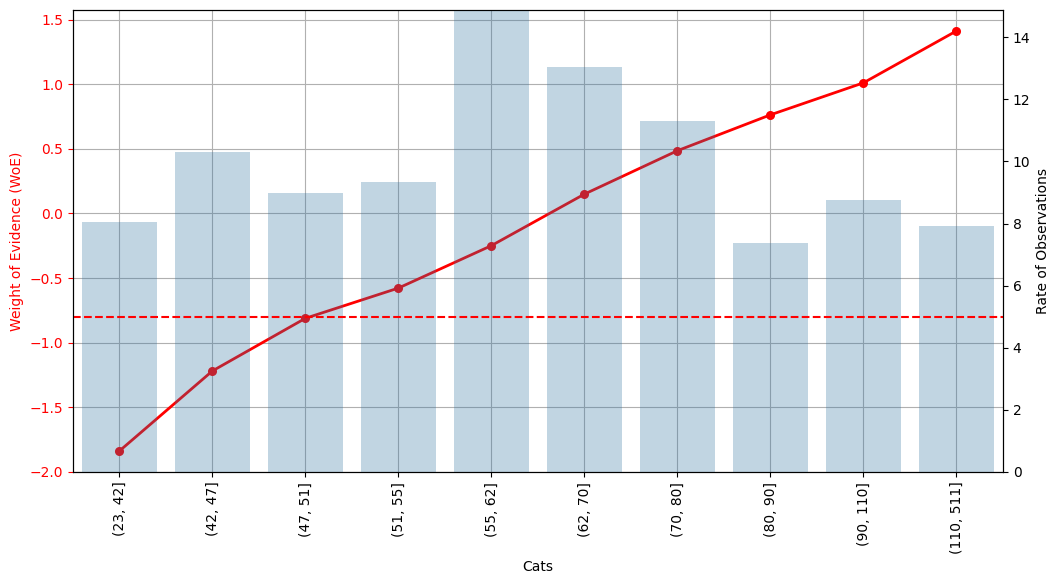

In [16]:
data['lfs_cat'] = pd.cut(data['Liver_Function_Score'], bins=[23, 42, 47, 51, 55, 62, 70, 80, 90, 110, 511])
woe_lfc = woe.WoE(df=data, feature_name='lfs_cat', target_name='smoking')
print("Sum of IV:", woe_lfc['IV'].sum())
woe.plot_woe(woe=woe_lfc)

### Cholesterol hdl ratio

Sum of IV: 0.31633558710717713


smoking  # of non-events  # of events  Percentage events  \
chr_cat                                                    
1                    828          229           0.041358   
2                   1450          414           0.074770   
3                   1262          455           0.082174   
4                   1766          717           0.129493   
5                   1461          807           0.145747   
6                   1275         1079           0.194871   
7                    592          617           0.111432   
8                    617          791           0.142857   
9                    212          428           0.077298   

smoking  Percentage non-events       WoE        IV  Total Observations  \
chr_cat                                                                  
1                     0.087499 -0.749355  0.034576                1057   
2                     0.153228 -0.717516  0.056295                1864   
3                     0.133362 -0.484219  0.024786                1717   
4                     0.186622 -0.365460  0.020878                2483   
5                     0.154391 -0.057616  0.000498                2268   
6                     0.134735  0.369025  0.022192                2354   
7                     0.062559  0.577299  0.028214                1209   
8                     0.065201  0.784366  0.060911                1408   
9                     0.022403  1.238474  0.067986                 640   

smoking  Percent of Observations  
chr_cat                           
1                          7.047  
2                         12.427  
3                         11.447  
4                         16.553  
5                         15.120  
6                         15.693  
7                          8.060  
8                          9.387  
9                          4.267

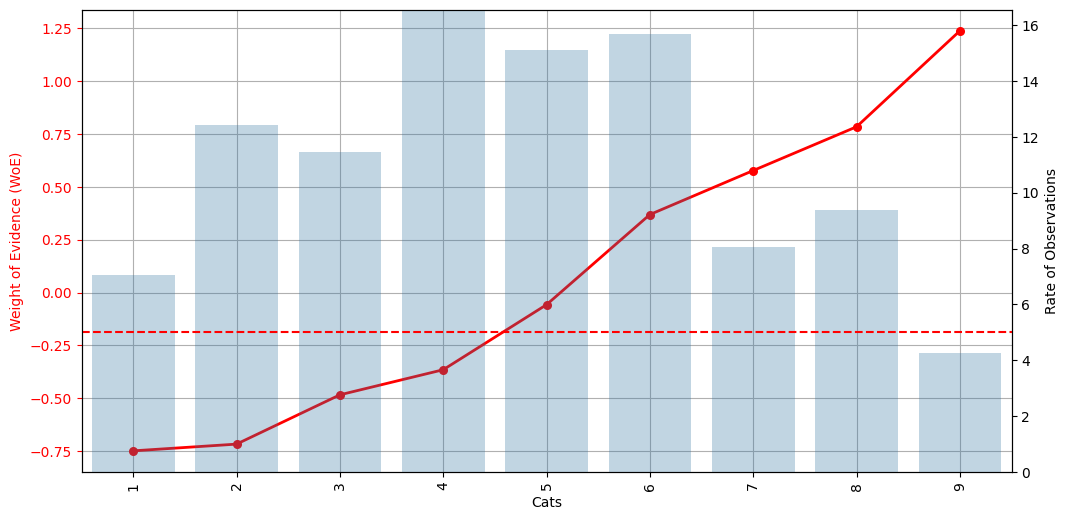

In [17]:
data['chr_cat'] = pd.cut(data['Cholesterol_HDL_Ratio'], bins=[1, 2.5, 2.8, 3, 3.3, 3.6, 4, 4.3, 4.9, 8], labels=list(range(1, 10)))
woe_chr = woe.WoE(df=data, feature_name='chr_cat', target_name='smoking')
print("Sum of IV:", woe_chr['IV'].sum())
woe.plot_woe(woe=woe_chr)

## fe woe

In [18]:
data = woe.features_with_woe(df=data)
print(data.shape)
data.head()

(15000, 37)


id   age  height(cm)  weight(kg)  waist(cm)  systolic  relaxation  \
0   0  55.0       170.0        80.0       92.0     129.0        74.0   
1   1  30.0       170.0        80.0       94.0     128.0        84.0   
2   2  45.0       170.0        75.0       84.0     124.0        80.0   
3   3  55.0       150.0        55.0       85.0     123.0        79.0   
4   4  45.0       160.0        55.0       72.0     117.0        76.0   

   fasting blood sugar  Cholesterol  triglyceride  ...  TG_HDL_Ratio  age_cat  \
0                 82.0        175.0          58.0  ...      1.183673        2   
1                 95.0        188.0         128.0  ...      2.509804        5   
2                 98.0        192.0         138.0  ...      2.653846        3   
3                 95.0        193.0          65.0  ...      1.065574        2   
4                103.0        197.0          81.0  ...      1.327869        3   

   hemoglobin_cat  height_cat  weight_cat  triglyceride_cat  hdl_cat  thr_cat  \
0               6           4           7                 1        5        3   
1               7           4           7                 7        4        8   
2               6           4           6                 7        4        8   
3               3           1           2                 2        3        3   
4               5           3           2                 4        3        4   

   lfs_cat  chr_cat  
0        5        5  
1       10        6  
2        8        6  
3        6        4  
4        5        4  

[5 rows x 37 columns]

## heatmap

interval columns not set, guessing: ['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries', 'smoking', 'BMI', 'BP_Category', 'Cholesterol_HDL_Ratio', 'Liver_Function_Score', 'Kidney_Health_Indicator', 'Combined_Eyesight', 'Combined_Hearing', 'TG_HDL_Ratio']


id   age  height(cm)  weight(kg)  waist(cm)  systolic  relaxation  \
0          0  55.0       170.0        80.0       92.0     129.0        74.0   
1          1  30.0       170.0        80.0       94.0     128.0        84.0   
2          2  45.0       170.0        75.0       84.0     124.0        80.0   
3          3  55.0       150.0        55.0       85.0     123.0        79.0   
4          4  45.0       160.0        55.0       72.0     117.0        76.0   
...      ...   ...         ...         ...        ...       ...         ...   
14995  14995  40.0       170.0        70.0       81.0     130.0        79.0   
14996  14996  40.0       155.0        50.0       75.0     100.0        60.0   
14997  14997  45.0       160.0        55.0       81.0     100.0        60.0   
14998  14998  50.0       160.0        60.0       80.0     120.0        80.0   
14999  14999  55.0       175.0        75.0       85.0     141.0        83.0   

       fasting blood sugar  Cholesterol  triglyceride  ...  TG_HDL_Ratio  \
0                     82.0        175.0          58.0  ...      1.183673   
1                     95.0        188.0         128.0  ...      2.509804   
2                     98.0        192.0         138.0  ...      2.653846   
3                     95.0        193.0          65.0  ...      1.065574   
4                    103.0        197.0          81.0  ...      1.327869   
...                    ...          ...           ...  ...           ...   
14995                 91.0        181.0         133.0  ...      2.829787   
14996                 83.0        169.0          59.0  ...      1.156863   
14997                 91.0        150.0          68.0  ...      1.743590   
14998                 90.0        258.0          97.0  ...      1.102273   
14999                108.0        187.0         111.0  ...      2.018182   

       age_cat  hemoglobin_cat  height_cat  weight_cat  triglyceride_cat  \
0            2               6           4           7                 1   
1            5               7           4           7                 7   
2            3               6           4           6                 7   
3            2               3           1           2                 2   
4            3               5           3           2                 4   
...        ...             ...         ...         ...               ...   
14995        4               7           4           5                 7   
14996        4               5           2           1                 1   
14997        3               7           3           2                 2   
14998        3               6           3           3                 5   
14999        2               4           4           6                 6   

       hdl_cat  thr_cat  lfs_cat  chr_cat  
0            5        3        5        5  
1            4        8       10        6  
2            4        8        8        6  
3            3        3        6        4  
4            3        4        5        4  
...        ...      ...      ...      ...  
14995        5        8        6        6  
14996        4        3        5        5  
14997        6        6        7        6  
14998        1        3        2        3  
14999        4        6        6        5  

[15000 rows x 37 columns]

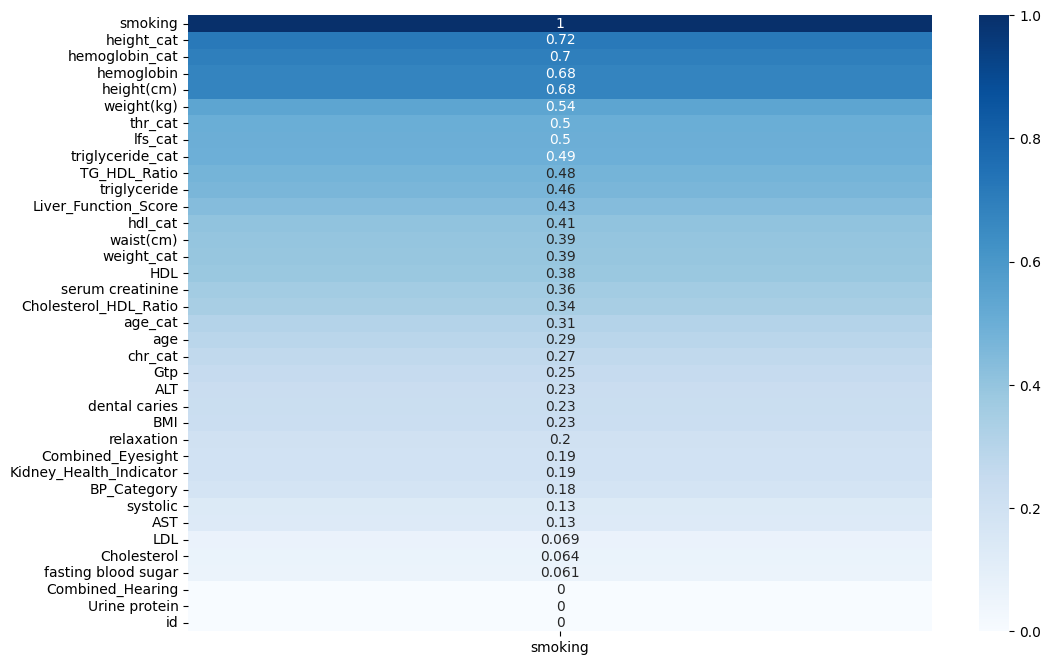

In [19]:
plots.heatmap_phik(df=data, target='smoking')

# modelling

In [20]:
train = pd.read_csv('data/train.csv')
train = fe.feature_engineering(df=train)
train = woe.features_with_woe(df=train)
cols_to_drop = fe.features_to_drop(df=train, target='smoking', threshold=0.25)
train.drop(columns=cols_to_drop, inplace=True)

test = pd.read_csv('data/test.csv')
id_col = test['id']
test = fe.feature_engineering(df=test)
test = woe.features_with_woe(df=test)
test.drop(columns=cols_to_drop, inplace=True)


print("train size:", train.shape)
print("test size:", test.shape)


X = train.drop(columns=['smoking'])
y = train['smoking']
seed = 1
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

train size: (15000, 22)
test size: (10000, 21)


In [21]:
# categoric columnlarni scale qilmaslik uchun
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), 
        np.arange(15))],
    remainder='passthrough'
)


pipeline_logis = Pipeline([
    ('scaler', preprocessor),
    ('poly', PolynomialFeatures(degree=2)),
    ('logistic', LogisticRegression())
])
pipeline_dt = Pipeline([
    ('scaler', preprocessor),  
    ('decisiontree', DecisionTreeClassifier(random_state=seed,
                                            min_samples_split = 30,
                                            min_samples_leaf = 10,
                                            max_features = 'sqrt', 
                                            max_depth = 6))
])
pipeline_bc = Pipeline([
    ('bagging', BaggingClassifier(DecisionTreeClassifier(random_state=seed,
                                                         max_depth=6,
                                                         min_samples_split=30,
                                                         min_samples_leaf = 10),
                                  n_estimators=159, 
                                  random_state=seed, 
                                  max_samples=.67))
])
pipeline_rf = Pipeline([
    ('randomForest', RandomForestClassifier(n_estimators= 199,
                                            min_samples_split= 20,
                                            min_samples_leaf= 5,
                                            max_features= 'sqrt',
                                            max_depth= 20,
                                            bootstrap=True,
                                            random_state=seed))
])
pipeline_svc = Pipeline([
    ('scaler', preprocessor),
    ('svc', SVC(random_state=seed, probability=True))
])

estimators = [
    ('logistic', pipeline_logis),
    ('decisionTree', pipeline_dt),
    ('bagging', pipeline_bc),
    ('randomForest', pipeline_rf),
    # ('svc', pipeline_svc)
]

learning curve for logistic

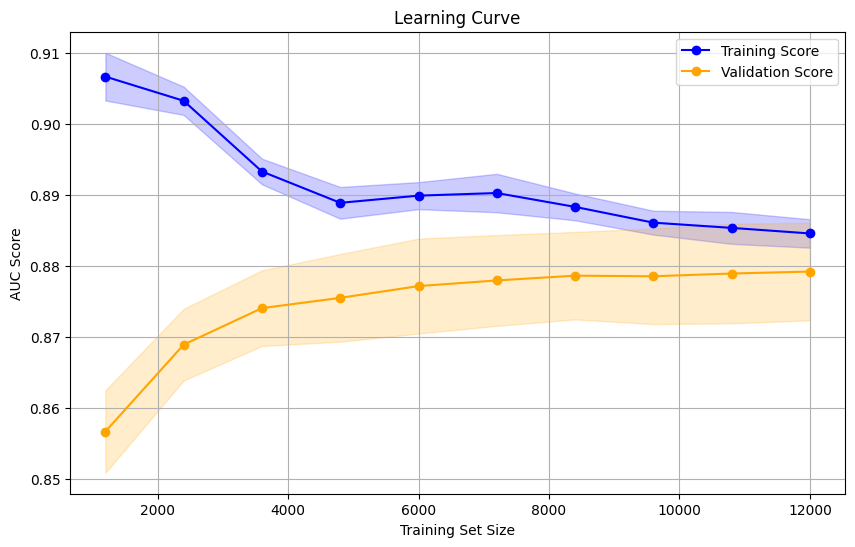

In [24]:
plots.plot_learning_curve(pipeline_logis, X, y)

learning curve for decisionTree

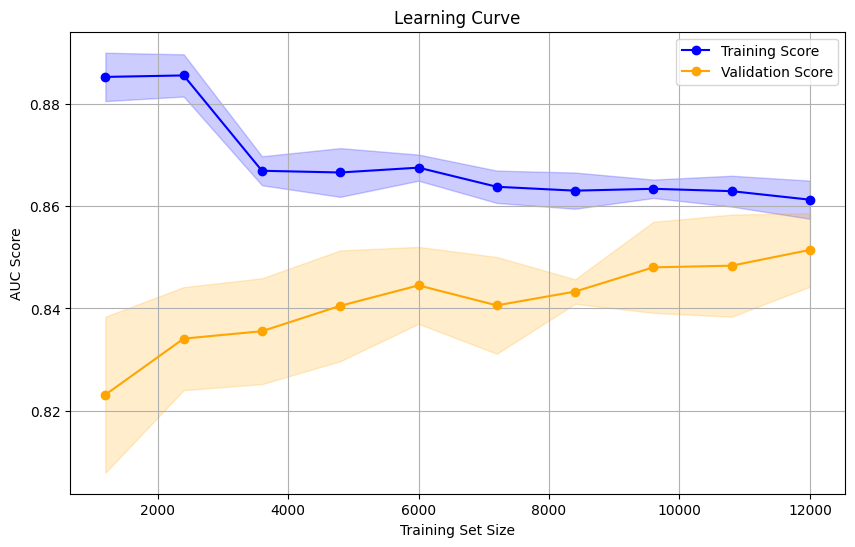

In [25]:
plots.plot_learning_curve(pipeline_dt, X, y)

learning curve for bagging

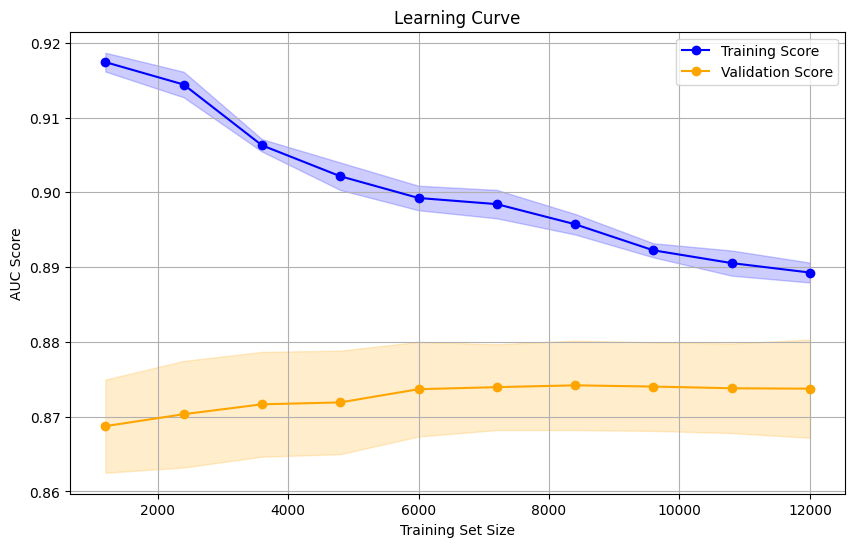

In [26]:

plots.plot_learning_curve(pipeline_bc, X, y)

learning curve for rf

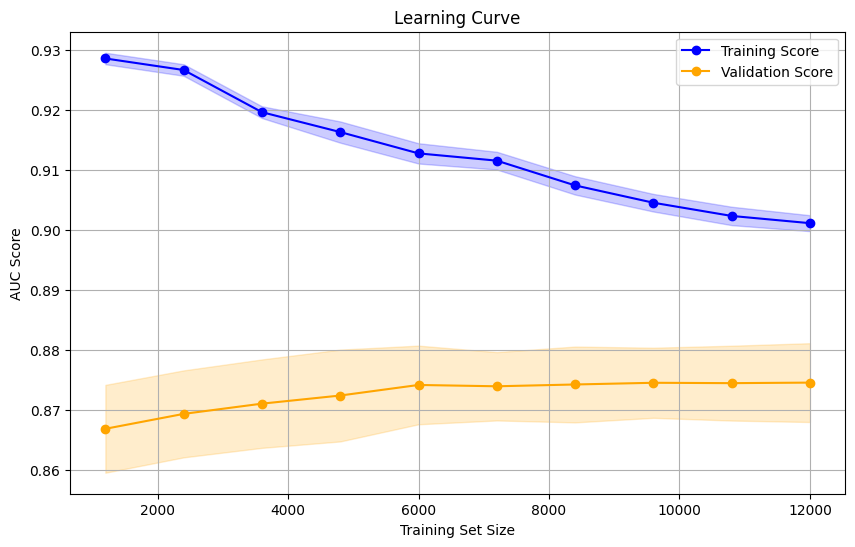

In [27]:
pipeline_rf = Pipeline([
    ('randomForest', RandomForestClassifier(n_estimators= 199,
                                            min_samples_split= 25,
                                            min_samples_leaf= 10,
                                            max_features= 'sqrt',
                                            max_depth= 8,
                                            bootstrap=True,
                                            random_state=seed))
])
plots.plot_learning_curve(pipeline_rf, X, y)

In [ ]:
# final model
stacking = StackingClassifier(estimators=estimators,
                              final_estimator=RandomForestClassifier(n_estimators= 399,
                                                                    min_samples_split= 30,
                                                                    min_samples_leaf= 10,
                                                                    max_features= 'sqrt',
                                                                    max_depth= 8,
                                                                    bootstrap=True,
                                                                    random_state=seed),
                              cv=skf,
                              passthrough=True
)

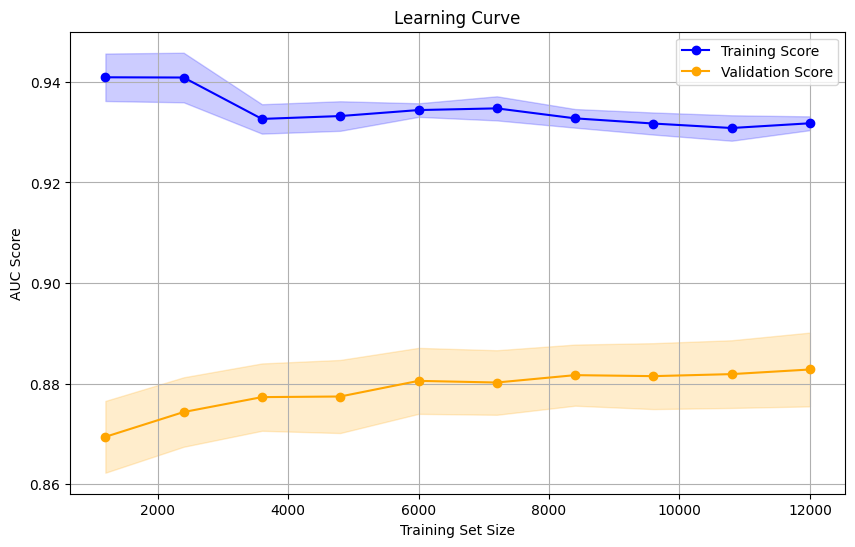

In [23]:
plots.plot_learning_curve(stacking, X, y)